# NOLH Experimental Design for Cost Sensitivity Analysis

This notebook uses **Nearly Orthogonal Latin Hypercube (NOLH)** sampling to efficiently explore the parameter space with fewer experiments than a full factorial design.

## Overview

NOLH sampling is a space-filling design that:
- Provides good coverage of the parameter space with fewer samples
- Ensures samples are well-distributed across all dimensions
- Is more efficient than full factorial designs for high-dimensional spaces

## Parameters Being Explored

- **num_docs**: 5-50 (number of document chunks to process)
- **chunk_size**: 256-4000 (tokens per chunk)
- **num_questions_per_doc**: 1-10 (questions generated per chunk)
- **gen_model**: Generation models (manually specified in Section 2)
- **embed_model**: Embedding models (manually specified in Section 2)

## How to Use

1. **Configure Parameters**: Adjust parameter ranges and number of samples in Section 2
2. **Generate Samples**: Execute Section 3 to generate NOLH sample points
3. **Run Experiments**: Execute Section 6 to run all experiments
4. **Analyze Results**: Review tables and visualizations in Sections 7-9


## Section 1: Setup and Imports


In [1]:
# Import standard library modules
import json
import sys
import time
from pathlib import Path
from typing import Dict, List, Optional, Any, Tuple

# Add the src directory to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import our custom modules
from src.config import Config
from src.pipeline import (
    load_document, 
    chunk_text, 
    embed_chunks, 
    generate_questions,
    save_chunks,
    save_metrics
)
from src.timing_metrics import MetricsStore
from src.reporting import aggregate_metrics, load_metrics
from src.token_accounting import count_tokens

# Import data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plots

# Import scipy for Latin Hypercube sampling
from scipy.stats import qmc

# Set up matplotlib for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
%matplotlib inline

print("Modules imported successfully!")


Modules imported successfully!


## Section 1.5: Optional - Discover Available Ollama Models

This section helps you see what models are available in your Ollama installation. This is optional - you can manually specify models in Section 2.


In [2]:
# Optional helper function to discover available Ollama models
# This helps you see what models you have installed before manually specifying them
import requests

def discover_ollama_models(base_url: str = "http://localhost:11434") -> List[str]:
    """
    Discover available models from Ollama API.
    
    This function queries the Ollama API to get a list of all available models.
    It's a helper function to see what models you have installed.
    
    Args:
        base_url: The base URL where Ollama is running (default: localhost:11434)
    
    Returns:
        List of model names (sorted alphabetically)
    
    Raises:
        ConnectionError: If Ollama is not running or not accessible
    """
    try:
        # Query Ollama's /api/tags endpoint to get available models
        # This endpoint lists all models without requiring any input
        url = f"{base_url}/api/tags"
        
        # Make a GET request with a timeout
        # GET is used because we're just asking for information, not sending data
        response = requests.get(url, timeout=5)
        
        # Check if the request was successful (HTTP 200)
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            
            # Extract model names from the response
            # Ollama returns models in a 'models' list, each with a 'name' field
            models = [model.get('name', '') for model in data.get('models', [])]
            
            # Sort models alphabetically for consistent ordering
            models.sort()
            
            return models
        else:
            # Got a response but it's an error
            raise ConnectionError(f"Ollama API returned status {response.status_code}: {response.text}")
            
    except requests.exceptions.ConnectionError as e:
        # Connection refused or couldn't reach the server
        raise ConnectionError(f"Could not connect to Ollama at {base_url}. Make sure Ollama is running.") from e
    except requests.exceptions.Timeout:
        # Request took too long
        raise ConnectionError(f"Connection to Ollama timed out. Check if Ollama is running at {base_url}.")
    except Exception as e:
        # Some other error
        raise ConnectionError(f"Error discovering models: {str(e)}") from e

# Try to discover models (optional - will show error if Ollama not running, but that's OK)
try:
    available_models = discover_ollama_models()
    print(f"✅ Found {len(available_models)} available models in Ollama:")
    for i, model in enumerate(available_models, 1):
        print(f"  {i}. {model}")
    print("\n💡 You can use these model names in Section 2 when specifying generation_models and embedding_models")
except ConnectionError as e:
    print(f"⚠️  Could not discover models: {e}")
    print("   This is OK - you can still manually specify models in Section 2")
    print("   Make sure Ollama is running if you want to use the discovery feature")


✅ Found 11 available models in Ollama:
  1. embeddinggemma:latest
  2. gemma3:12b
  3. gemma3:1b
  4. gemma3:27b
  5. gemma3:4b
  6. gpt-oss:120b
  7. gpt-oss:20b
  8. nomic-embed-text:137m-v1.5-fp16
  9. qwen3-embedding:8b-fp16
  10. qwen3:latest
  11. snowflake-arctic-embed2:568m

💡 You can use these model names in Section 2 when specifying generation_models and embedding_models


In [ ]:
# Set up paths
from datetime import datetime

base_config = Config()

# Create timestamped experiments directory for better organization
# Format: nolh_YYYYMMDD_HHMMSS
experiment_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiments_dir = base_config.results_dir / "experiments" / f"nolh_{experiment_timestamp}"
experiments_dir.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {base_config.results_dir}")
print(f"NOLH experiments directory: {experiments_dir}")
print(f"Experiment timestamp: {experiment_timestamp}")

# Document path (using MobyDick.txt as example)
document_path = project_root / "MobyDick.txt"
print(f"Document path: {document_path}")


Results directory: results
NOLH experiments directory: results/experiments/nolh
Document path: /home/goble54/spark-dev-workspace/GenerativeAI-Cost-Estimator/MobyDick.txt


## Section 2: NOLH Parameter Configuration

Define the parameter ranges and model configurations for all experiments.

**IMPORTANT**: You must manually specify which models to use for generation and embedding below.


In [4]:
# ============================================================================
# USER INPUT: Specify Models to Use
# ============================================================================
# IMPORTANT: Edit these lists to specify which models you want to test
# 
# Examples:
#   generation_models = ['gemma3:1b', 'gemma3:4b']
#   embedding_models = ['embeddinggemma']
#
# You can see available models by running Section 1.5 above (optional)

# List of generation models to test
# These models will be used for text generation (question generation)
# Add or remove model names as needed
generation_models = [
    'gemma3:1b',      # Example: Gemma 3 1B model
    'gemma3:4b',      # Example: Gemma 3 4B model
    'gemma3:12b',      # Example: Gemma 3 12B model
    'gemma3:27b',     # Example: Gemma 3 16B model
    'gpt-oss:20b',     # Example: GPT-OSS 20B model
    'qwen3:latest',   # Example: Qwen 3 2B model
    'gpt-oss:120b',    # Example: GPT-OSS 120B model
    # Add more generation models here if you have them
]

# List of embedding models to test
# These models will be used for creating embeddings
# Add or remove model names as needed
embedding_models = [
    'embeddinggemma',  # Example: Gemma embedding model
    'qwen3-embedding:8b-fp16',
    'snowflake-arctic-embed2:568m',
    'nomic-embed-text:137m-v1.5-fp16',
    # Add more embedding models here if you have them
]

# Validate that model lists are not empty
if len(generation_models) == 0:
    raise ValueError("generation_models list cannot be empty! Please specify at least one generation model.")
if len(embedding_models) == 0:
    raise ValueError("embedding_models list cannot be empty! Please specify at least one embedding model.")

# Store models for later use
available_gen_models = generation_models
available_embed_models = embedding_models

print("✅ Model configuration:")
print(f"  Generation models ({len(available_gen_models)}): {available_gen_models}")
print(f"  Embedding models ({len(available_embed_models)}): {available_embed_models}")
print(f"  Total model combinations: {len(available_gen_models) * len(available_embed_models)}")

# ============================================================================
# Parameter Ranges for NOLH Sampling
# ============================================================================
# These define the bounds of our experimental space
# Now includes model indices as additional dimensions
parameter_ranges = {
    'num_docs': (5, 50),           # Number of document chunks: 5 to 50
    'chunk_size': (256, 4000),      # Chunk size in tokens: 256 to 4000
    'num_questions_per_doc': (1, 10),  # Questions per chunk: 1 to 10
    'gen_model_idx': (0, len(available_gen_models) - 1),    # Generation model index (discrete)
    'embed_model_idx': (0, len(available_embed_models) - 1)  # Embedding model index (discrete)
}

# Number of samples to generate
# Recommended: 20-30 samples for 5 parameters (3 continuous + 2 discrete)
# More samples = better coverage but more experiments to run
num_samples = 30

# Fixed parameters (same for all experiments)
# Note: gen_model and embed_model are now sampled, not fixed
fixed_config = {
    'concurrency': 3,  # Sequential processing
}

# Pricing configurations (from notebook 04)
# We'll calculate costs for BOTH API and local pricing for every experiment
api_pricing_config = {
    'mode': 'api',
    'price_per_1k_tokens_input': 0.00250,
    'price_per_1k_tokens_output': 0.01000
}

local_pricing_config = {
    'mode': 'local',
    'dollars_per_gpu_hour': 1.50
}

# Chunk overlap calculation: 10% of chunk_size, but capped at 50
# This will be calculated per experiment based on chunk_size
def calculate_chunk_overlap(chunk_size: int) -> int:
    """Calculate chunk overlap as 10% of chunk_size, capped at 50."""
    overlap = int(chunk_size * 0.1)
    return min(overlap, 50)

print("\n✅ Parameter configuration:")
print(f"  Parameter ranges: {parameter_ranges}")
print(f"  Number of samples: {num_samples}")
print(f"  Fixed config: {fixed_config}")
print(f"  API pricing: {api_pricing_config}")
print(f"  Local pricing: {local_pricing_config}")


✅ Model configuration:
  Generation models (7): ['gemma3:1b', 'gemma3:4b', 'gemma3:12b', 'gemma3:27b', 'gpt-oss:20b', 'qwen3:latest', 'gpt-oss:120b']
  Embedding models (4): ['embeddinggemma', 'qwen3-embedding:8b-fp16', 'snowflake-arctic-embed2:568m', 'nomic-embed-text:137m-v1.5-fp16']
  Total model combinations: 28

✅ Parameter configuration:
  Parameter ranges: {'num_docs': (5, 50), 'chunk_size': (256, 4000), 'num_questions_per_doc': (1, 10), 'gen_model_idx': (0, 6), 'embed_model_idx': (0, 3)}
  Number of samples: 30
  Fixed config: {'concurrency': 3}
  API pricing: {'mode': 'api', 'price_per_1k_tokens_input': 0.0025, 'price_per_1k_tokens_output': 0.01}
  Local pricing: {'mode': 'local', 'dollars_per_gpu_hour': 1.5}


### Model Information Summary

Display the model configuration and parameter ranges including model indices.


In [5]:
# Display model information and parameter ranges
print("="*70)
print("Model Configuration Summary")
print("="*70)

print(f"\n📊 Generation Models ({len(available_gen_models)}):")
for idx, model in enumerate(available_gen_models):
    print(f"   Index {idx}: {model}")

print(f"\n📊 Embedding Models ({len(available_embed_models)}):")
for idx, model in enumerate(available_embed_models):
    print(f"   Index {idx}: {model}")

print(f"\n📊 Total Model Combinations: {len(available_gen_models) * len(available_embed_models)}")
print(f"   (Each NOLH sample will randomly select one generation model and one embedding model)")

print(f"\n📊 Parameter Ranges:")
print(f"   num_docs: {parameter_ranges['num_docs'][0]} to {parameter_ranges['num_docs'][1]}")
print(f"   chunk_size: {parameter_ranges['chunk_size'][0]} to {parameter_ranges['chunk_size'][1]} tokens")
print(f"   num_questions_per_doc: {parameter_ranges['num_questions_per_doc'][0]} to {parameter_ranges['num_questions_per_doc'][1]}")
print(f"   gen_model_idx: {parameter_ranges['gen_model_idx'][0]} to {parameter_ranges['gen_model_idx'][1]} (maps to generation models above)")
print(f"   embed_model_idx: {parameter_ranges['embed_model_idx'][0]} to {parameter_ranges['embed_model_idx'][1]} (maps to embedding models above)")

print(f"\n📊 NOLH Design:")
print(f"   Dimensions: 5 (3 continuous + 2 discrete model indices)")
print(f"   Number of samples: {num_samples}")
print("="*70)


Model Configuration Summary

📊 Generation Models (7):
   Index 0: gemma3:1b
   Index 1: gemma3:4b
   Index 2: gemma3:12b
   Index 3: gemma3:27b
   Index 4: gpt-oss:20b
   Index 5: qwen3:latest
   Index 6: gpt-oss:120b

📊 Embedding Models (4):
   Index 0: embeddinggemma
   Index 1: qwen3-embedding:8b-fp16
   Index 2: snowflake-arctic-embed2:568m
   Index 3: nomic-embed-text:137m-v1.5-fp16

📊 Total Model Combinations: 28
   (Each NOLH sample will randomly select one generation model and one embedding model)

📊 Parameter Ranges:
   num_docs: 5 to 50
   chunk_size: 256 to 4000 tokens
   num_questions_per_doc: 1 to 10
   gen_model_idx: 0 to 6 (maps to generation models above)
   embed_model_idx: 0 to 3 (maps to embedding models above)

📊 NOLH Design:
   Dimensions: 5 (3 continuous + 2 discrete model indices)
   Number of samples: 30


## Section 3: NOLH Sample Generation

Generate well-distributed sample points in the 5D parameter space using Latin Hypercube sampling.

**Note**: The design now includes 5 dimensions:
- 3 continuous: num_docs, chunk_size, num_questions_per_doc
- 2 discrete: gen_model_idx, embed_model_idx (will be mapped to model names)


In [6]:
# Generate Latin Hypercube samples
# Latin Hypercube ensures good space-filling properties
# We use scipy's qmc.LatinHypercube which is optimized for this purpose
# Now generating 5-dimensional samples (3 continuous + 2 discrete model indices)
sampler = qmc.LatinHypercube(d=5, seed=42)  # 5 dimensions: num_docs, chunk_size, num_questions, gen_model_idx, embed_model_idx
samples = sampler.random(n=num_samples)  # Generate normalized samples [0, 1]

# Map normalized samples [0, 1] to actual parameter ranges
# This converts each dimension from [0, 1] to the actual parameter range
nolh_samples = []
for sample in samples:
    # Map continuous dimensions (0, 1, 2)
    # Dimension 0: num_docs
    num_docs = int(np.round(
        parameter_ranges['num_docs'][0] + 
        sample[0] * (parameter_ranges['num_docs'][1] - parameter_ranges['num_docs'][0])
    ))
    # Dimension 1: chunk_size
    chunk_size = int(np.round(
        parameter_ranges['chunk_size'][0] + 
        sample[1] * (parameter_ranges['chunk_size'][1] - parameter_ranges['chunk_size'][0])
    ))
    # Dimension 2: num_questions_per_doc
    num_questions = int(np.round(
        parameter_ranges['num_questions_per_doc'][0] + 
        sample[2] * (parameter_ranges['num_questions_per_doc'][1] - parameter_ranges['num_questions_per_doc'][0])
    ))
    
    # Map discrete dimensions (3, 4) - model indices
    # Dimension 3: gen_model_idx (discrete)
    gen_model_idx_float = (
        parameter_ranges['gen_model_idx'][0] + 
        sample[3] * (parameter_ranges['gen_model_idx'][1] - parameter_ranges['gen_model_idx'][0])
    )
    gen_model_idx = int(np.round(gen_model_idx_float))
    
    # Dimension 4: embed_model_idx (discrete)
    embed_model_idx_float = (
        parameter_ranges['embed_model_idx'][0] + 
        sample[4] * (parameter_ranges['embed_model_idx'][1] - parameter_ranges['embed_model_idx'][0])
    )
    embed_model_idx = int(np.round(embed_model_idx_float))
    
    # Ensure values are within bounds (rounding might push them slightly out)
    num_docs = max(parameter_ranges['num_docs'][0], min(parameter_ranges['num_docs'][1], num_docs))
    chunk_size = max(parameter_ranges['chunk_size'][0], min(parameter_ranges['chunk_size'][1], chunk_size))
    num_questions = max(parameter_ranges['num_questions_per_doc'][0], 
                       min(parameter_ranges['num_questions_per_doc'][1], num_questions))
    
    # Clamp model indices to valid ranges
    gen_model_idx = max(parameter_ranges['gen_model_idx'][0], 
                       min(parameter_ranges['gen_model_idx'][1], gen_model_idx))
    embed_model_idx = max(parameter_ranges['embed_model_idx'][0], 
                         min(parameter_ranges['embed_model_idx'][1], embed_model_idx))
    
    nolh_samples.append({
        'num_docs': num_docs,
        'chunk_size': chunk_size,
        'num_questions_per_doc': num_questions,
        'gen_model_idx': gen_model_idx,      # Will be mapped to model name later
        'embed_model_idx': embed_model_idx   # Will be mapped to model name later
    })

# Display the generated samples
samples_df = pd.DataFrame(nolh_samples)
print(f"Generated {len(nolh_samples)} NOLH sample points (5 dimensions):")
print("\nSample points (first 10):")
print(samples_df.head(10).to_string(index=False))
print(f"\nParameter statistics:")
print(samples_df.describe())
print(f"\nModel index distributions:")
print(f"  gen_model_idx range: {samples_df['gen_model_idx'].min()} to {samples_df['gen_model_idx'].max()}")
print(f"  embed_model_idx range: {samples_df['embed_model_idx'].min()} to {samples_df['embed_model_idx'].max()}")


Generated 30 NOLH sample points (5 dimensions):

Sample points (first 10):
 num_docs  chunk_size  num_questions_per_doc  gen_model_idx  embed_model_idx
       43         326                      4              6                2
       17        1783                      7              1                3
       16        2137                      4              5                0
       45        1560                      9              1                3
       11        2708                      5              2                1
       42        3567                      4              5                0
       47        2756                      9              3                1
       11        3485                      6              3                2
       36         776                      8              4                1
       20        1705                      6              4                2

Parameter statistics:
       num_docs   chunk_size  num_questions_per_doc  ge

## Section 4: Experiment Configuration Generation

Convert each NOLH sample point into a complete experiment configuration with proper naming.


In [7]:
# Convert NOLH samples to experiment configurations
# Each experiment gets a name that includes its parameter values for easy identification
# Model indices from NOLH samples are mapped to actual model names here
experiments = []

for i, sample in enumerate(nolh_samples):
    # Map model indices to actual model names
    # Extract model indices from the sample (these were generated by NOLH sampling)
    gen_model_idx = sample['gen_model_idx']
    embed_model_idx = sample['embed_model_idx']
    
    # Map integer indices to actual model names from the user-specified lists
    # These lists were defined in Section 2
    gen_model = available_gen_models[gen_model_idx]
    embed_model = available_embed_models[embed_model_idx]
    
    # Generate experiment name with parameter labels including model info
    # Format: nolh_docs{num}_chunk{size}_q{questions}_gen{model}_emb{model}
    # Use shortened model names in the experiment name to keep it readable
    gen_model_short = gen_model.replace(':', '_').replace('-', '_')
    embed_model_short = embed_model.replace(':', '_').replace('-', '_')
    exp_name = f"nolh_docs{sample['num_docs']}_chunk{sample['chunk_size']}_q{sample['num_questions_per_doc']}_gen{gen_model_short}_emb{embed_model_short}"
    
    # Calculate chunk overlap based on chunk_size
    chunk_overlap = calculate_chunk_overlap(sample['chunk_size'])
    
    # Create experiment configuration dictionary
    exp_config = {
        'name': exp_name,
        'gen_model': gen_model,              # Mapped from index to actual model name
        'embed_model': embed_model,          # Mapped from index to actual model name
        'num_docs': sample['num_docs'],
        'chunk_size': sample['chunk_size'],
        'chunk_overlap': chunk_overlap,
        'num_questions_per_doc': sample['num_questions_per_doc'],
        'concurrency': fixed_config['concurrency']
    }
    
    experiments.append(exp_config)

print(f"Generated {len(experiments)} experiment configurations")
print("\nFirst 5 experiments:")
for exp in experiments[:5]:
    print(f"  {exp['name']}")
    print(f"    docs={exp['num_docs']}, chunk={exp['chunk_size']}, questions={exp['num_questions_per_doc']}")
    print(f"    gen_model={exp['gen_model']}, embed_model={exp['embed_model']}")


Generated 30 experiment configurations

First 5 experiments:
  nolh_docs43_chunk326_q4_gengpt_oss_120b_embsnowflake_arctic_embed2_568m
    docs=43, chunk=326, questions=4
    gen_model=gpt-oss:120b, embed_model=snowflake-arctic-embed2:568m
  nolh_docs17_chunk1783_q7_gengemma3_4b_embnomic_embed_text_137m_v1.5_fp16
    docs=17, chunk=1783, questions=7
    gen_model=gemma3:4b, embed_model=nomic-embed-text:137m-v1.5-fp16
  nolh_docs16_chunk2137_q4_genqwen3_latest_embembeddinggemma
    docs=16, chunk=2137, questions=4
    gen_model=qwen3:latest, embed_model=embeddinggemma
  nolh_docs45_chunk1560_q9_gengemma3_4b_embnomic_embed_text_137m_v1.5_fp16
    docs=45, chunk=1560, questions=9
    gen_model=gemma3:4b, embed_model=nomic-embed-text:137m-v1.5-fp16
  nolh_docs11_chunk2708_q5_gengemma3_12b_embqwen3_embedding_8b_fp16
    docs=11, chunk=2708, questions=5
    gen_model=gemma3:12b, embed_model=qwen3-embedding:8b-fp16


## Section 5: Helper Functions

Reuse helper functions from the cost sensitivity analysis notebook for cost calculation and experiment execution.


In [8]:
def calculate_costs(metrics: Dict[str, Any], api_pricing_config: Dict[str, Any], 
                    local_pricing_config: Dict[str, Any]) -> Dict[str, Any]:
    """
    Calculate costs for BOTH API and local pricing models.
    
    This function takes aggregated metrics and both pricing configurations,
    then computes costs for both API pricing (per-token) and local pricing (per-hour).
    
    Args:
        metrics: Dictionary with aggregated metrics (from aggregate_metrics)
        api_pricing_config: API pricing configuration dict
        local_pricing_config: Local pricing configuration dict
    
    Returns:
        Dictionary containing:
        - 'api_costs': Dictionary with API cost breakdown
        - 'local_costs': Dictionary with local cost breakdown
        - 'total_input_tokens', 'total_output_tokens', 'total_tokens', 'total_runtime_seconds'
    """
    # Extract token and time metrics from the aggregated metrics dictionary
    # These come from the embedding and inference operations
    embedding_tokens = metrics.get('embedding', {}).get('total_tokens', 0)
    inference_prompt_tokens = metrics.get('inference', {}).get('total_prompt_tokens', 0)
    inference_response_tokens = metrics.get('inference', {}).get('total_response_tokens', 0)
    
    # Calculate total input tokens (embedding + prompt tokens) and output tokens (response tokens)
    total_input_tokens = embedding_tokens + inference_prompt_tokens
    total_output_tokens = inference_response_tokens
    total_tokens = total_input_tokens + total_output_tokens
    
    # Get total runtime in seconds
    total_runtime_seconds = metrics.get('overall', {}).get('total_time_seconds', 0)
    
    # Calculate API costs (per-token pricing)
    price_per_1k_input = api_pricing_config.get('price_per_1k_tokens_input', 0.0)
    price_per_1k_output = api_pricing_config.get('price_per_1k_tokens_output', 0.0)
    
    api_cost_input = (total_input_tokens / 1000.0) * price_per_1k_input
    api_cost_output = (total_output_tokens / 1000.0) * price_per_1k_output
    api_total_cost = api_cost_input + api_cost_output
    
    api_costs = {
        'cost_input': api_cost_input,
        'cost_output': api_cost_output,
        'total_cost': api_total_cost,
        'cost_per_1k_tokens': (api_total_cost / total_tokens * 1000) if total_tokens > 0 else 0,
        'pricing_mode': 'api'
    }
    
    # Calculate local costs (per-hour pricing)
    dollars_per_hour = local_pricing_config.get('dollars_per_gpu_hour', 0.0)
    runtime_hours = total_runtime_seconds / 3600.0
    local_total_cost = runtime_hours * dollars_per_hour
    
    local_costs = {
        'runtime_hours': runtime_hours,
        'total_cost': local_total_cost,
        'cost_per_1k_tokens': (local_total_cost / total_tokens * 1000) if total_tokens > 0 else 0,
        'pricing_mode': 'local'
    }
    
    # Return combined results
    return {
        'api_costs': api_costs,
        'local_costs': local_costs,
        'total_input_tokens': total_input_tokens,
        'total_output_tokens': total_output_tokens,
        'total_tokens': total_tokens,
        'total_runtime_seconds': total_runtime_seconds
    }


print("Cost calculation function defined")


Cost calculation function defined


In [9]:
def run_experiment(exp_config: Dict[str, Any], document_path: Path, 
                  experiments_dir: Path, reuse_chunks: bool = True) -> Dict[str, Any]:
    """
    Run a single experiment.
    
    This function orchestrates the entire experiment pipeline:
    1. Creates a Config object from the experiment configuration
    2. Loads and chunks the document (or reuses existing chunks)
    3. Runs embedding pipeline for the specified number of chunks
    4. Runs question generation pipeline
    5. Collects and aggregates all metrics
    6. Calculates costs
    7. Returns experiment results
    
    Args:
        exp_config: Experiment configuration dictionary with all parameters
        document_path: Path to the document file to process
        experiments_dir: Directory to save experiment results
        reuse_chunks: If True, try to reuse existing chunks from previous runs
    
    Returns:
        Dictionary with experiment results including metrics and costs
    """
    print(f"\n{'='*70}")
    print(f"Running experiment: {exp_config['name']}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    # Create Config object from experiment configuration
    # This config object will be used throughout the pipeline
    config = Config(
        embedding_model=exp_config['embed_model'],
        generation_model=exp_config['gen_model'],
        chunk_size_tokens=exp_config['chunk_size'],
        chunk_overlap_tokens=exp_config.get('chunk_overlap', 50),
        chunking_strategy='fixed_token_window'
    )
    
    # Create metrics store for this experiment
    # This will track all token counts and timings
    metrics_store = MetricsStore()
    
    # Load and chunk document (or reuse existing chunks)
    # For efficiency, we can reuse chunks if they exist and match our config
    chunks_path = config.get_chunks_path()
    
    if reuse_chunks and chunks_path.exists():
        # Try to load existing chunks from a previous run
        try:
            with open(chunks_path, 'r') as f:
                all_chunks = json.load(f)
            print(f"Loaded {len(all_chunks)} existing chunks")
        except:
            all_chunks = None
    else:
        all_chunks = None
    
    if all_chunks is None:
        # Need to create chunks from scratch
        print("Loading and chunking document...")
        text = load_document(document_path)
        all_chunks = chunk_text(text, config)
        print(f"Created {len(all_chunks)} chunks")
    
    # Select subset of chunks based on num_docs
    # This allows us to test with different numbers of documents
    num_docs = exp_config.get('num_docs')
    if num_docs is None or num_docs > len(all_chunks):
        selected_chunks = all_chunks
    else:
        selected_chunks = all_chunks[:num_docs]
    
    print(f"Processing {len(selected_chunks)} chunks for this experiment")
    
    # Extract chunk text (remove embeddings if present to save memory)
    # We'll regenerate embeddings anyway, so we don't need old ones
    chunks_for_embedding = []
    for chunk in selected_chunks:
        chunk_copy = {k: v for k, v in chunk.items() if k != 'embedding'}
        chunks_for_embedding.append(chunk_copy)
    
    # Run embedding pipeline
    # This generates vector embeddings for each chunk
    print("Embedding chunks...")
    embedded_chunks = embed_chunks(chunks_for_embedding, config, metrics_store)
    print(f"Embedded {len(embedded_chunks)} chunks")
    
    # Run question generation pipeline
    # This generates questions for each chunk using the LLM
    print(f"Generating questions ({exp_config['num_questions_per_doc']} per chunk)...")
    all_questions = []
    
    # Process chunks sequentially (concurrency can be added later if needed)
    for chunk in embedded_chunks:
        questions = generate_questions(
            chunk,
            exp_config['num_questions_per_doc'],
            config,
            metrics_store
        )
        all_questions.extend(questions)
    
    print(f"Generated {len(all_questions)} questions")
    
    # Aggregate metrics
    # Convert metrics store to DataFrame for aggregation
    metrics_df = pd.DataFrame(metrics_store.metrics)
    aggregated = aggregate_metrics(metrics_df)
    
    # Calculate costs for BOTH API and local pricing models
    # Note: api_pricing_config and local_pricing_config are defined in Section 2
    costs = calculate_costs(aggregated, api_pricing_config, local_pricing_config)
    
    # Extract cost values for easier access
    api_costs = costs['api_costs']
    local_costs = costs['local_costs']
    
    # Calculate additional metrics
    total_questions = len(all_questions)
    total_chunks = len(embedded_chunks)
    
    # Calculate derived metrics like tokens per second
    tokens_per_second = aggregated.get('overall', {}).get('tokens_per_second', 0)
    
    # Calculate cost difference and ratio
    cost_difference = api_costs['total_cost'] - local_costs['total_cost']
    cost_ratio = api_costs['total_cost'] / local_costs['total_cost'] if local_costs['total_cost'] > 0 else 0
    
    # Build experiment results dictionary
    # This contains all the information we'll analyze later
    results = {
        'experiment_name': exp_config['name'],
        'gen_model': exp_config['gen_model'],
        'embed_model': exp_config['embed_model'],
        'num_docs': len(selected_chunks),
        'chunk_size': exp_config['chunk_size'],
        'chunk_overlap': exp_config.get('chunk_overlap', 50),
        'num_questions_per_doc': exp_config['num_questions_per_doc'],
        'total_questions': total_questions,
        'concurrency': exp_config.get('concurrency', 1),
        'total_input_tokens': costs['total_input_tokens'],
        'total_output_tokens': costs['total_output_tokens'],
        'total_tokens': costs['total_tokens'],
        'total_runtime_seconds': costs['total_runtime_seconds'],
        'tokens_per_second': tokens_per_second,
        # API costs
        'cost_api_total': api_costs['total_cost'],
        'cost_api_per_1k_tokens': api_costs['cost_per_1k_tokens'],
        'cost_api_per_document': api_costs['total_cost'] / len(selected_chunks) if len(selected_chunks) > 0 else 0,
        'cost_api_per_question': api_costs['total_cost'] / total_questions if total_questions > 0 else 0,
        'cost_api_input': api_costs['cost_input'],
        'cost_api_output': api_costs['cost_output'],
        # Local costs
        'cost_local_total': local_costs['total_cost'],
        'cost_local_per_1k_tokens': local_costs['cost_per_1k_tokens'],
        'cost_local_per_document': local_costs['total_cost'] / len(selected_chunks) if len(selected_chunks) > 0 else 0,
        'cost_local_per_question': local_costs['total_cost'] / total_questions if total_questions > 0 else 0,
        'cost_local_runtime_hours': local_costs['runtime_hours'],
        # Cost comparison metrics
        'cost_difference': cost_difference,  # API - Local (positive = API more expensive)
        'cost_ratio': cost_ratio,  # API / Local (ratio > 1 = API more expensive)
        # Backward compatibility (use API costs as default)
        'total_cost': api_costs['total_cost'],
        'cost_per_1k_tokens': api_costs['cost_per_1k_tokens'],
        'cost_per_document': api_costs['total_cost'] / len(selected_chunks) if len(selected_chunks) > 0 else 0,
        'cost_per_question': api_costs['total_cost'] / total_questions if total_questions > 0 else 0,
        'pricing_mode': 'both',  # Indicates both pricing models were calculated
        'aggregated_metrics': aggregated,
        'costs': costs
    }
    
    # Save experiment metrics to disk
    exp_metrics_path = experiments_dir / f"{exp_config['name']}_metrics.json"
    save_metrics(metrics_store, exp_metrics_path)
    print(f"Saved metrics to {exp_metrics_path}")
    
    elapsed = time.time() - start_time
    print(f"Experiment completed in {elapsed:.2f} seconds")
    
    return results


print("Experiment runner function defined")


Experiment runner function defined


## Section 6: Experiment Execution Loop

Run all NOLH-generated experiments and collect results.


In [10]:
# Execute all experiments
# This loop runs each experiment configuration and collects the results
all_results = []
failed_experiments = []

print(f"Starting execution of {len(experiments)} experiments...")
print(f"Total estimated time: ~{len(experiments) * 2} minutes (rough estimate)")

for i, exp_config in enumerate(experiments, 1):
    try:
        print(f"\n[{i}/{len(experiments)}] Processing experiment: {exp_config['name']}")
        
        # Run the experiment
        result = run_experiment(
            exp_config, 
            document_path, 
            experiments_dir,
            reuse_chunks=True  # Reuse chunks to save time
        )
        
        # Add NOLH sample point coordinates to results for analysis
        # Find the corresponding sample point
        sample_idx = i - 1
        result['nolh_sample_idx'] = sample_idx
        result['nolh_num_docs'] = nolh_samples[sample_idx]['num_docs']
        result['nolh_chunk_size'] = nolh_samples[sample_idx]['chunk_size']
        result['nolh_num_questions'] = nolh_samples[sample_idx]['num_questions_per_doc']
        
        all_results.append(result)
        print(f"✓ Experiment {i} completed successfully")
        
    except Exception as e:
        print(f"✗ Experiment {i} failed: {str(e)}")
        failed_experiments.append({
            'experiment': exp_config['name'],
            'error': str(e)
        })
        import traceback
        traceback.print_exc()

print(f"\n{'='*70}")
print(f"Experiment execution complete!")
print(f"  Successful: {len(all_results)}")
print(f"  Failed: {len(failed_experiments)}")
if failed_experiments:
    print(f"\nFailed experiments:")
    for fail in failed_experiments:
        print(f"  - {fail['experiment']}: {fail['error']}")


Starting execution of 30 experiments...
Total estimated time: ~60 minutes (rough estimate)

[1/30] Processing experiment: nolh_docs43_chunk326_q4_gengpt_oss_120b_embsnowflake_arctic_embed2_568m

Running experiment: nolh_docs43_chunk326_q4_gengpt_oss_120b_embsnowflake_arctic_embed2_568m
Loaded 772 existing chunks
Processing 43 chunks for this experiment
Embedding chunks...


Embedded 43 chunks
Generating questions (4 per chunk)...
Generated 172 questions
Saved metrics to results/experiments/nolh/nolh_docs43_chunk326_q4_gengpt_oss_120b_embsnowflake_arctic_embed2_568m_metrics.json
Experiment completed in 325.75 seconds
✓ Experiment 1 completed successfully

[2/30] Processing experiment: nolh_docs17_chunk1783_q7_gengemma3_4b_embnomic_embed_text_137m_v1.5_fp16

Running experiment: nolh_docs17_chunk1783_q7_gengemma3_4b_embnomic_embed_text_137m_v1.5_fp16
Loaded 772 existing chunks
Processing 17 chunks for this experiment
Embedding chunks...
Embedded 17 chunks
Generating questions (7 per chunk)...
Generated 119 questions
Saved metrics to results/experiments/nolh/nolh_docs17_chunk1783_q7_gengemma3_4b_embnomic_embed_text_137m_v1.5_fp16_metrics.json
Experiment completed in 31.83 seconds
✓ Experiment 2 completed successfully

[3/30] Processing experiment: nolh_docs16_chunk2137_q4_genqwen3_latest_embembeddinggemma

Running experiment: nolh_docs16_chunk2137_q4_genqwen3

## Section 7: Results Aggregation

Collect all experiment results into a summary DataFrame for analysis.


In [ ]:
# Build summary DataFrame from all results
# Extract key metrics from each experiment result
summary_data = []

for result in all_results:
    summary_data.append({
        'experiment_name': result['experiment_name'],
        'gen_model': result['gen_model'],
        'embed_model': result['embed_model'],
        'num_docs': result['num_docs'],
        'chunk_size': result['chunk_size'],
        'chunk_overlap': result['chunk_overlap'],
        'num_questions_per_doc': result['num_questions_per_doc'],
        'total_questions': result['total_questions'],
        'concurrency': result['concurrency'],
        'total_input_tokens': result['total_input_tokens'],
        'total_output_tokens': result['total_output_tokens'],
        'total_tokens': result['total_tokens'],
        'total_runtime_seconds': result['total_runtime_seconds'],
        'tokens_per_second': result['tokens_per_second'],
        # API costs
        'cost_api_total': result.get('cost_api_total', 0),
        'cost_api_per_1k_tokens': result.get('cost_api_per_1k_tokens', 0),
        'cost_api_per_document': result.get('cost_api_per_document', 0),
        'cost_api_per_question': result.get('cost_api_per_question', 0),
        'cost_api_input': result.get('cost_api_input', 0),
        'cost_api_output': result.get('cost_api_output', 0),
        # Local costs
        'cost_local_total': result.get('cost_local_total', 0),
        'cost_local_per_1k_tokens': result.get('cost_local_per_1k_tokens', 0),
        'cost_local_per_document': result.get('cost_local_per_document', 0),
        'cost_local_per_question': result.get('cost_local_per_question', 0),
        'cost_local_runtime_hours': result.get('cost_local_runtime_hours', 0),
        # Cost comparison metrics
        'cost_difference': result.get('cost_difference', 0),  # API - Local
        'cost_ratio': result.get('cost_ratio', 0),  # API / Local
        # Backward compatibility fields
        'total_cost': result.get('total_cost', result.get('cost_api_total', 0)),
        'cost_per_1k_tokens': result.get('cost_per_1k_tokens', result.get('cost_api_per_1k_tokens', 0)),
        'cost_per_document': result.get('cost_per_document', result.get('cost_api_per_document', 0)),
        'cost_per_question': result.get('cost_per_question', result.get('cost_api_per_question', 0)),
        'pricing_mode': result.get('pricing_mode', 'both'),
        # Include NOLH sample coordinates
        'nolh_sample_idx': result.get('nolh_sample_idx', -1),
        'nolh_num_docs': result.get('nolh_num_docs', result['num_docs']),
        'nolh_chunk_size': result.get('nolh_chunk_size', result['chunk_size']),
        'nolh_num_questions': result.get('nolh_num_questions', result['num_questions_per_doc'])
    })

summary_df = pd.DataFrame(summary_data)

# Save summary to CSV with timestamp
# Use the experiment_timestamp from the directory name for consistency
summary_path = experiments_dir / f"nolh_summary_{experiment_timestamp}.csv"
summary_df.to_csv(summary_path, index=False)
print(f"Summary saved to: {summary_path}")
print(f"\nSummary statistics:")
print(summary_df.describe())


Summary saved to: results/experiments/nolh/nolh_summary.csv

Summary statistics:
       num_docs   chunk_size  chunk_overlap  num_questions_per_doc  \
count  30.00000    30.000000      30.000000              30.000000   
mean   27.50000  2123.766667      49.166667               5.500000   
std    13.26065  1105.462196       3.484778               2.596417   
min     6.00000   326.000000      32.000000               1.000000   
25%    16.25000  1237.500000      50.000000               3.250000   
50%    28.00000  2114.000000      50.000000               5.500000   
75%    37.75000  3037.500000      50.000000               7.750000   
max    50.00000  3959.000000      50.000000              10.000000   

       total_questions  concurrency  total_input_tokens  total_output_tokens  \
count        30.000000         30.0           30.000000                 30.0   
mean        147.100000          3.0        13393.266667                  0.0   
std         109.171599          0.0         6428

In [12]:
# Display formatted summary table
# Show key metrics in a readable format with both API and local costs
display_columns = [
    'experiment_name', 'num_docs', 'chunk_size', 'num_questions_per_doc',
    'total_tokens', 'total_runtime_seconds',
    'cost_api_total', 'cost_local_total', 'cost_difference', 'cost_ratio',
    'cost_api_per_1k_tokens', 'cost_local_per_1k_tokens',
    'cost_api_per_document', 'cost_local_per_document'
]

print("Experiment Summary (API vs Local Costs):")
print("=" * 150)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

# Format numeric columns for better readability
display_df = summary_df[display_columns].copy()
display_df['cost_api_total'] = display_df['cost_api_total'].apply(lambda x: f"${x:.4f}")
display_df['cost_local_total'] = display_df['cost_local_total'].apply(lambda x: f"${x:.4f}")
display_df['cost_difference'] = display_df['cost_difference'].apply(lambda x: f"${x:+.4f}")  # + sign shows positive/negative
display_df['cost_ratio'] = display_df['cost_ratio'].apply(lambda x: f"{x:.3f}x")
display_df['cost_api_per_1k_tokens'] = display_df['cost_api_per_1k_tokens'].apply(lambda x: f"${x:.4f}")
display_df['cost_local_per_1k_tokens'] = display_df['cost_local_per_1k_tokens'].apply(lambda x: f"${x:.4f}")
display_df['cost_api_per_document'] = display_df['cost_api_per_document'].apply(lambda x: f"${x:.4f}")
display_df['cost_local_per_document'] = display_df['cost_local_per_document'].apply(lambda x: f"${x:.4f}")
display_df['total_runtime_seconds'] = display_df['total_runtime_seconds'].apply(lambda x: f"{x:.2f}s")

try:
    display(display_df)
except:
    print(display_df.to_string())


Experiment Summary (API vs Local Costs):


,experiment_name,num_docs,chunk_size,num_questions_per_doc,total_tokens,total_runtime_seconds,cost_api_total,cost_local_total,cost_difference,cost_ratio,cost_api_per_1k_tokens,cost_local_per_1k_tokens,cost_api_per_document,cost_local_per_document
0,nolh_docs43_chunk326_q4_ge...,43,326,4,20825,325.50s,$0.0521,$0.1356,$-0.0836,0.384x,$0.0025,$0.0065,$0.0012,$0.0032
1,nolh_docs17_chunk1783_q7_g...,17,1783,7,8337,31.69s,$0.0208,$0.0132,$+0.0076,1.579x,$0.0025,$0.0016,$0.0012,$0.0008
2,nolh_docs16_chunk2137_q4_g...,16,2137,4,7829,199.96s,$0.0196,$0.0833,$-0.0637,0.235x,$0.0025,$0.0106,$0.0012,$0.0052
3,nolh_docs45_chunk1560_q9_g...,45,1560,9,21825,95.18s,$0.0546,$0.0397,$+0.0149,1.376x,$0.0025,$0.0018,$0.0012,$0.0009
4,nolh_docs11_chunk2708_q5_g...,11,2708,5,5358,52.20s,$0.0134,$0.0217,$-0.0084,0.616x,$0.0025,$0.0041,$0.0012,$0.0020
5,nolh_docs42_chunk3567_q4_g...,42,3567,4,20394,519.37s,$0.0510,$0.2164,$-0.1654,0.236x,$0.0025,$0.0106,$0.0012,$0.0052
6,nolh_docs47_chunk2756_q9_g...,47,2756,9,22821,576.73s,$0.0571,$0.2403,$-0.1833,0.237x,$0.0025,$0.0105,$0.0012,$0.0051
7,nolh_docs11_chunk3485_q6_g...,11,3485,6,5358,92.36s,$0.0134,$0.0385,$-0.0251,0.348x,$0.0025,$0.0072,$0.0012,$0.0035
8,nolh_docs36_chunk776_q8_ge...,36,776,8,17533,354.44s,$0.0438,$0.1477,$-0.1038,0.297x,$0.0025,$0.0084,$0.0012,$0.0041
9,nolh_docs20_chunk1705_q6_g...,20,1705,6,9755,133.05s,$0.0244,$0.0554,$-0.0310,0.440x,$0.0025,$0.0057,$0.0012,$0.0028


## Section 8: Analysis and Visualization

Create visualizations to understand parameter relationships and their impact on cost, tokens, and runtime.


Saved parameter space analysis plot to: results/experiments/nolh/nolh_parameter_space_analysis.png


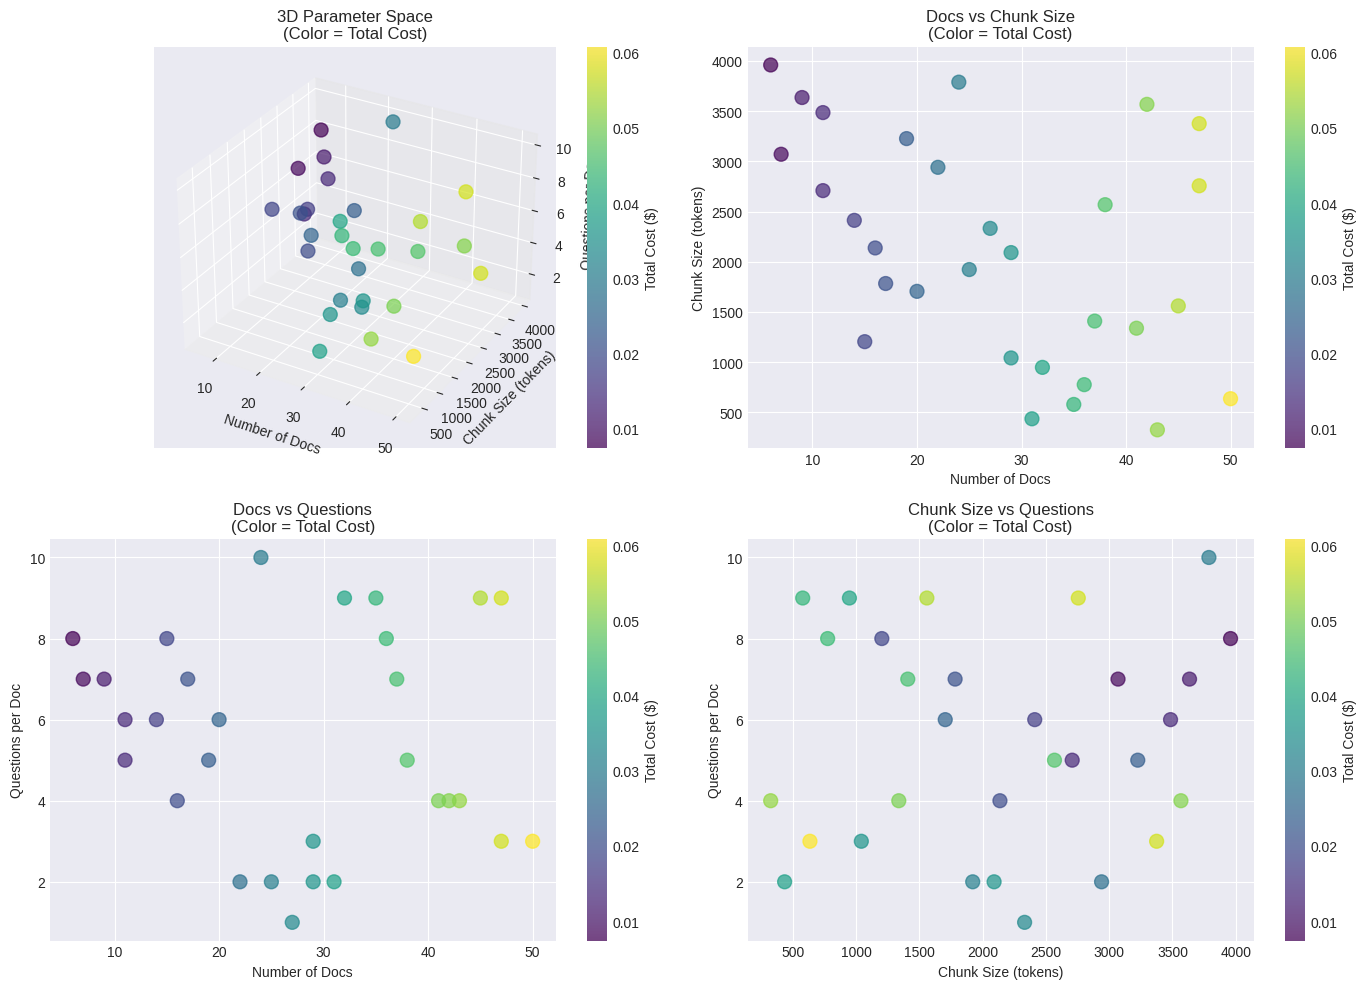

In [13]:
# 1. 3D Scatter Plot: Parameter Space with Cost Coloring
# This shows how cost varies across the 3D parameter space
fig = plt.figure(figsize=(14, 10))

# Create 3D subplot
ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(
    summary_df['num_docs'],
    summary_df['chunk_size'],
    summary_df['num_questions_per_doc'],
    c=summary_df['total_cost'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
ax1.set_xlabel('Number of Docs')
ax1.set_ylabel('Chunk Size (tokens)')
ax1.set_zlabel('Questions per Doc')
ax1.set_title('3D Parameter Space\n(Color = Total Cost)')
plt.colorbar(scatter, ax=ax1, label='Total Cost ($)')

# 2. Pairwise Parameter Plots
# These show relationships between pairs of parameters

# num_docs vs chunk_size
ax2 = fig.add_subplot(222)
scatter2 = ax2.scatter(
    summary_df['num_docs'],
    summary_df['chunk_size'],
    c=summary_df['total_cost'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
ax2.set_xlabel('Number of Docs')
ax2.set_ylabel('Chunk Size (tokens)')
ax2.set_title('Docs vs Chunk Size\n(Color = Total Cost)')
plt.colorbar(scatter2, ax=ax2, label='Total Cost ($)')

# num_docs vs num_questions_per_doc
ax3 = fig.add_subplot(223)
scatter3 = ax3.scatter(
    summary_df['num_docs'],
    summary_df['num_questions_per_doc'],
    c=summary_df['total_cost'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
ax3.set_xlabel('Number of Docs')
ax3.set_ylabel('Questions per Doc')
ax3.set_title('Docs vs Questions\n(Color = Total Cost)')
plt.colorbar(scatter3, ax=ax3, label='Total Cost ($)')

# chunk_size vs num_questions_per_doc
ax4 = fig.add_subplot(224)
scatter4 = ax4.scatter(
    summary_df['chunk_size'],
    summary_df['num_questions_per_doc'],
    c=summary_df['total_cost'],
    cmap='viridis',
    s=100,
    alpha=0.7
)
ax4.set_xlabel('Chunk Size (tokens)')
ax4.set_ylabel('Questions per Doc')
ax4.set_title('Chunk Size vs Questions\n(Color = Total Cost)')
plt.colorbar(scatter4, ax=ax4, label='Total Cost ($)')

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_parameter_space_analysis.png', dpi=150, bbox_inches='tight')
print(f"Saved parameter space analysis plot to: {experiments_dir / 'nolh_parameter_space_analysis.png'}")
plt.show()


Saved response surface plots to: results/experiments/nolh/nolh_response_surfaces.png


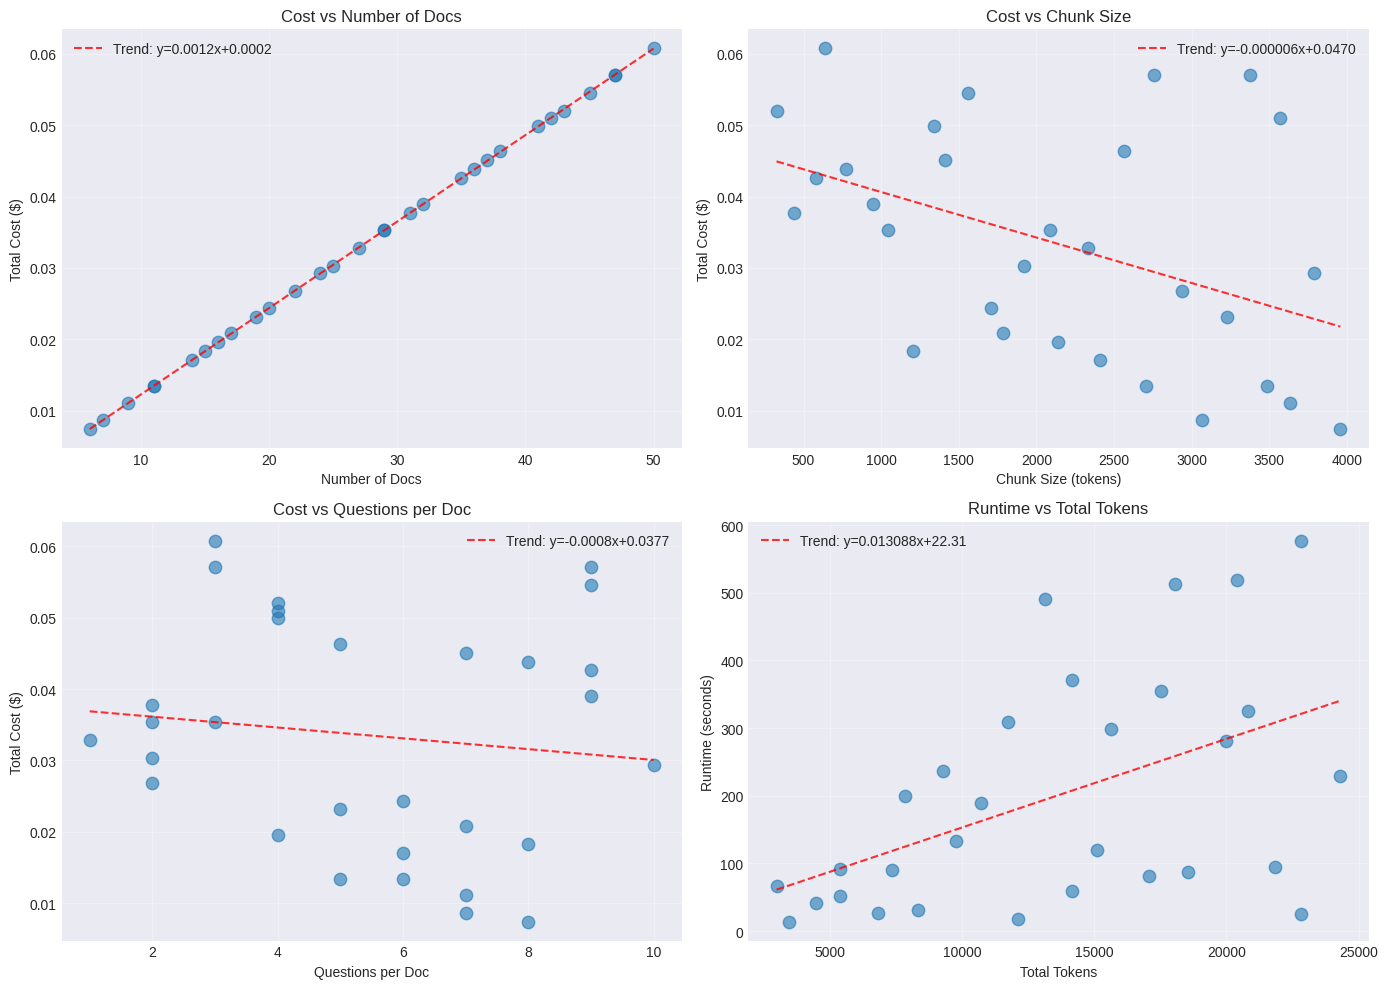

In [14]:
# Response Surface Plots: Cost vs Parameters
# These show how cost changes as we vary each parameter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cost vs Number of Docs
ax1 = axes[0, 0]
ax1.scatter(summary_df['num_docs'], summary_df['total_cost'], alpha=0.6, s=80)
# Add trend line
z = np.polyfit(summary_df['num_docs'], summary_df['total_cost'], 1)
p = np.poly1d(z)
ax1.plot(summary_df['num_docs'].sort_values(), p(summary_df['num_docs'].sort_values()), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
ax1.set_xlabel('Number of Docs')
ax1.set_ylabel('Total Cost ($)')
ax1.set_title('Cost vs Number of Docs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cost vs Chunk Size
ax2 = axes[0, 1]
ax2.scatter(summary_df['chunk_size'], summary_df['total_cost'], alpha=0.6, s=80)
z = np.polyfit(summary_df['chunk_size'], summary_df['total_cost'], 1)
p = np.poly1d(z)
ax2.plot(summary_df['chunk_size'].sort_values(), p(summary_df['chunk_size'].sort_values()), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.6f}x+{z[1]:.4f}')
ax2.set_xlabel('Chunk Size (tokens)')
ax2.set_ylabel('Total Cost ($)')
ax2.set_title('Cost vs Chunk Size')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Cost vs Questions per Doc
ax3 = axes[1, 0]
ax3.scatter(summary_df['num_questions_per_doc'], summary_df['total_cost'], alpha=0.6, s=80)
z = np.polyfit(summary_df['num_questions_per_doc'], summary_df['total_cost'], 1)
p = np.poly1d(z)
ax3.plot(summary_df['num_questions_per_doc'].sort_values(), 
         p(summary_df['num_questions_per_doc'].sort_values()), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
ax3.set_xlabel('Questions per Doc')
ax3.set_ylabel('Total Cost ($)')
ax3.set_title('Cost vs Questions per Doc')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Runtime vs Total Tokens
ax4 = axes[1, 1]
ax4.scatter(summary_df['total_tokens'], summary_df['total_runtime_seconds'], alpha=0.6, s=80)
z = np.polyfit(summary_df['total_tokens'], summary_df['total_runtime_seconds'], 1)
p = np.poly1d(z)
ax4.plot(summary_df['total_tokens'].sort_values(), 
         p(summary_df['total_tokens'].sort_values()), 
         "r--", alpha=0.8, label=f'Trend: y={z[0]:.6f}x+{z[1]:.2f}')
ax4.set_xlabel('Total Tokens')
ax4.set_ylabel('Runtime (seconds)')
ax4.set_title('Runtime vs Total Tokens')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_response_surfaces.png', dpi=150, bbox_inches='tight')
print(f"Saved response surface plots to: {experiments_dir / 'nolh_response_surfaces.png'}")
plt.show()


## Section 8.1: API vs Local Cost Comparison

Visualizations that clearly show the differences between API and local pricing models.


Saved side-by-side cost comparison to: results/experiments/nolh/nolh_cost_comparison_bars.png


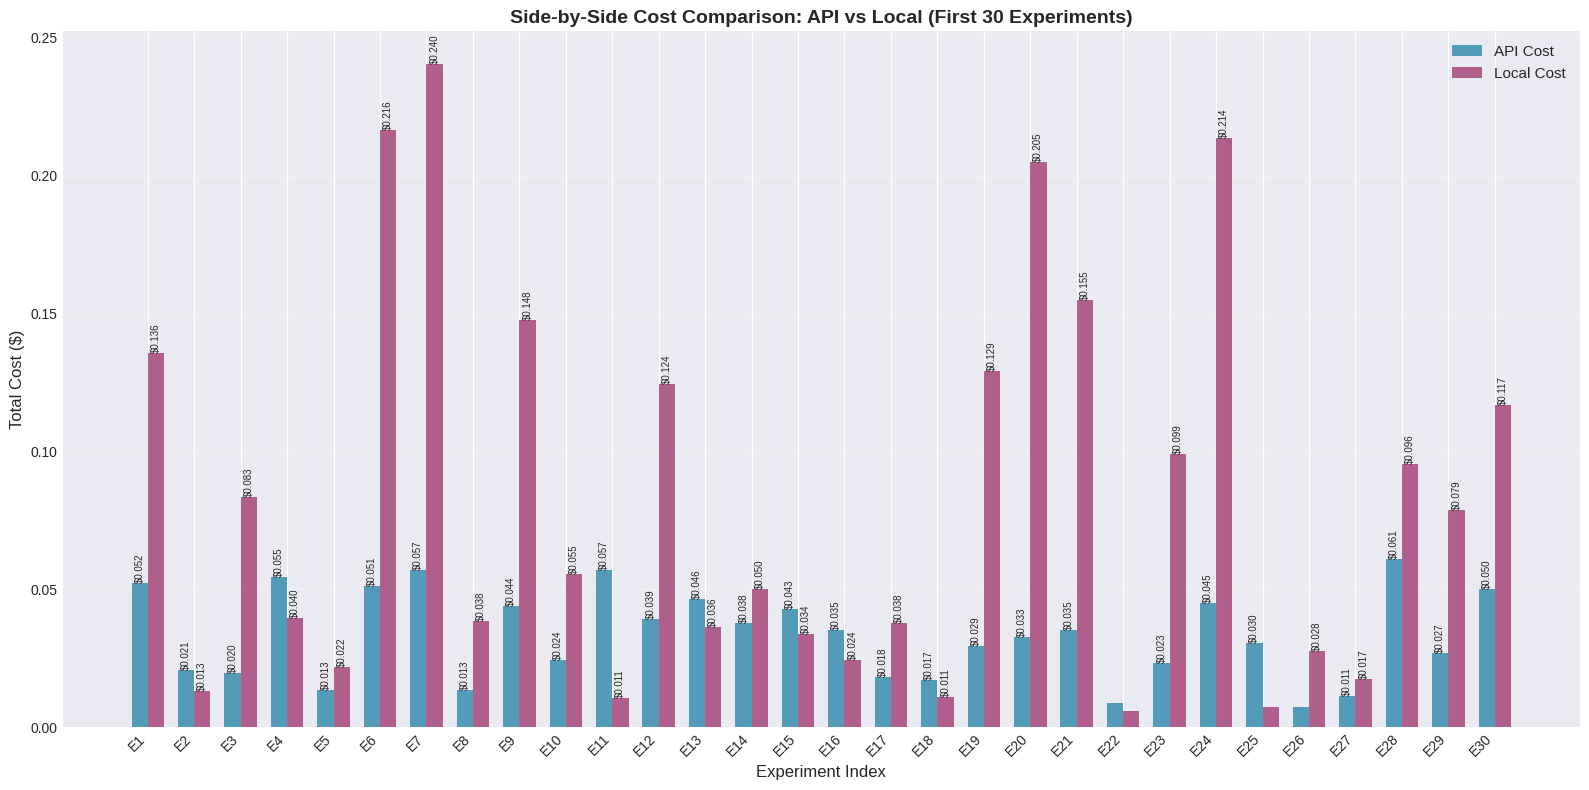

In [15]:
# a) Side-by-Side Cost Comparison
# Bar chart showing API cost vs Local cost for each experiment
fig, ax = plt.subplots(figsize=(16, 8))

# Select a subset of experiments for readability (or show all if not too many)
num_to_show = min(30, len(summary_df))
display_df = summary_df.head(num_to_show).copy()

x = np.arange(len(display_df))
width = 0.35

# Create grouped bars
bars1 = ax.bar(x - width/2, display_df['cost_api_total'], width, label='API Cost', alpha=0.8, color='#2E86AB')
bars2 = ax.bar(x + width/2, display_df['cost_local_total'], width, label='Local Cost', alpha=0.8, color='#A23B72')

ax.set_xlabel('Experiment Index', fontsize=12)
ax.set_ylabel('Total Cost ($)', fontsize=12)
ax.set_title(f'Side-by-Side Cost Comparison: API vs Local (First {num_to_show} Experiments)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f"E{i+1}" for i in range(len(display_df))], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # Only label if significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'${height:.3f}',
                   ha='center', va='bottom', fontsize=7, rotation=90)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_cost_comparison_bars.png', dpi=150, bbox_inches='tight')
print(f"Saved side-by-side cost comparison to: {experiments_dir / 'nolh_cost_comparison_bars.png'}")
plt.show()


Saved API vs Local cost scatter plot to: results/experiments/nolh/nolh_cost_scatter_comparison.png


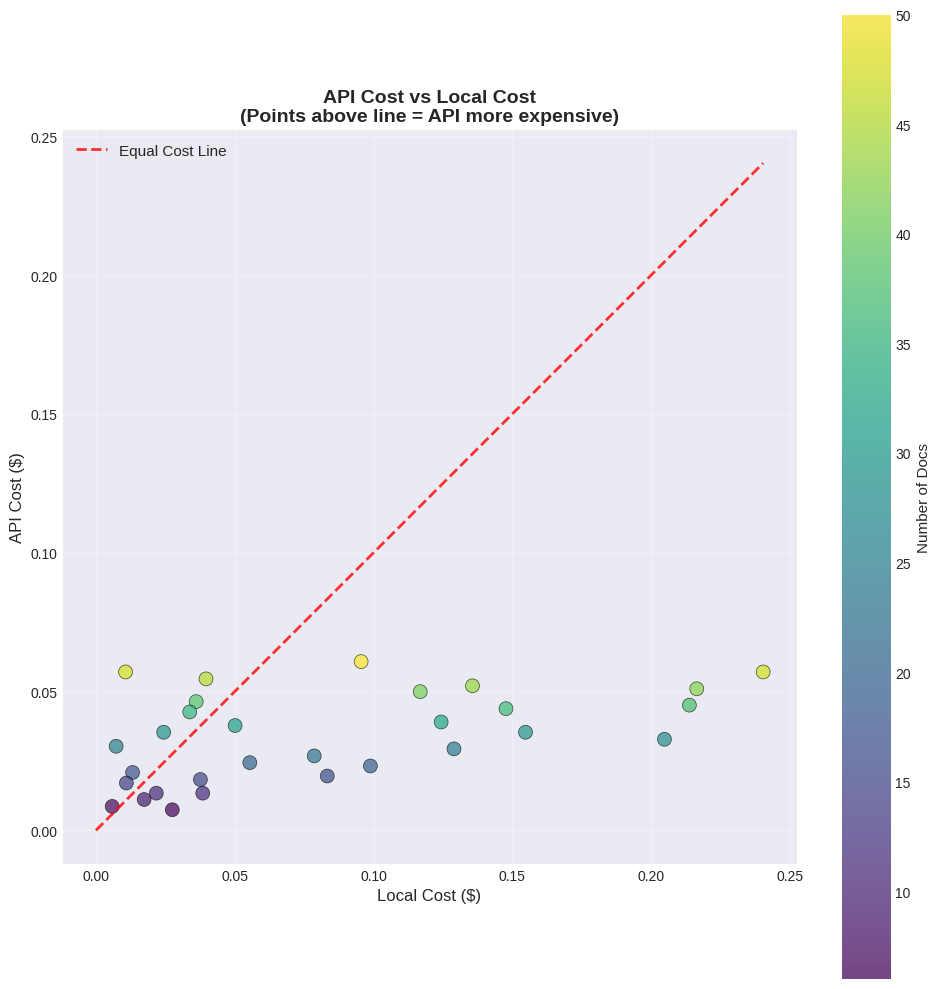

In [16]:
# b) Scatter Plot: API vs Local Costs
# X-axis: Local cost, Y-axis: API cost
# Points above diagonal = API more expensive, below = Local more expensive
fig, ax = plt.subplots(figsize=(10, 10))

# Color points by number of docs to show parameter relationships
scatter = ax.scatter(
    summary_df['cost_local_total'],
    summary_df['cost_api_total'],
    c=summary_df['num_docs'],
    cmap='viridis',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)

# Add diagonal reference line (y=x) where costs are equal
max_cost = max(summary_df['cost_api_total'].max(), summary_df['cost_local_total'].max())
ax.plot([0, max_cost], [0, max_cost], 'r--', linewidth=2, label='Equal Cost Line', alpha=0.8)

ax.set_xlabel('Local Cost ($)', fontsize=12)
ax.set_ylabel('API Cost ($)', fontsize=12)
ax.set_title('API Cost vs Local Cost\n(Points above line = API more expensive)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Docs', fontsize=11)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_cost_scatter_comparison.png', dpi=150, bbox_inches='tight')
print(f"Saved API vs Local cost scatter plot to: {experiments_dir / 'nolh_cost_scatter_comparison.png'}")
plt.show()


Saved cost difference histogram to: results/experiments/nolh/nolh_cost_difference_histogram.png


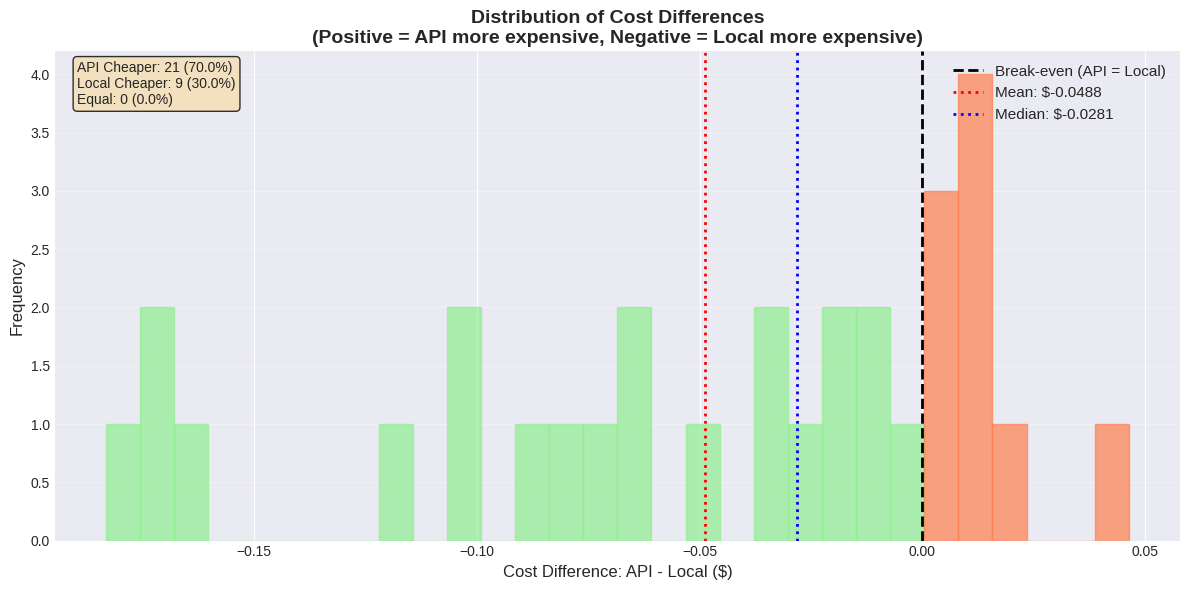

In [17]:
# c) Cost Difference Analysis
# Histogram of cost differences (API - Local)
fig, ax = plt.subplots(figsize=(12, 6))

# Create histogram
n, bins, patches = ax.hist(summary_df['cost_difference'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')

# Color bars: red for positive (API more expensive), green for negative (Local more expensive)
for i, (bar, bin_val) in enumerate(zip(patches, bins[:-1])):
    if bin_val >= 0:
        bar.set_color('coral')  # API more expensive
    else:
        bar.set_color('lightgreen')  # Local more expensive

# Add vertical line at 0 to show break-even point
ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Break-even (API = Local)')

# Add statistics text
mean_diff = summary_df['cost_difference'].mean()
median_diff = summary_df['cost_difference'].median()
ax.axvline(x=mean_diff, color='red', linestyle=':', linewidth=2, label=f'Mean: ${mean_diff:.4f}')
ax.axvline(x=median_diff, color='blue', linestyle=':', linewidth=2, label=f'Median: ${median_diff:.4f}')

ax.set_xlabel('Cost Difference: API - Local ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Cost Differences\n(Positive = API more expensive, Negative = Local more expensive)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add text box with summary statistics
api_cheaper = (summary_df['cost_difference'] < 0).sum()
local_cheaper = (summary_df['cost_difference'] > 0).sum()
equal = (summary_df['cost_difference'] == 0).sum()
total = len(summary_df)

textstr = f'API Cheaper: {api_cheaper} ({api_cheaper/total*100:.1f}%)\n'
textstr += f'Local Cheaper: {local_cheaper} ({local_cheaper/total*100:.1f}%)\n'
textstr += f'Equal: {equal} ({equal/total*100:.1f}%)'

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_cost_difference_histogram.png', dpi=150, bbox_inches='tight')
print(f"Saved cost difference histogram to: {experiments_dir / 'nolh_cost_difference_histogram.png'}")
plt.show()


Saved cost ratio analysis to: results/experiments/nolh/nolh_cost_ratio_analysis.png


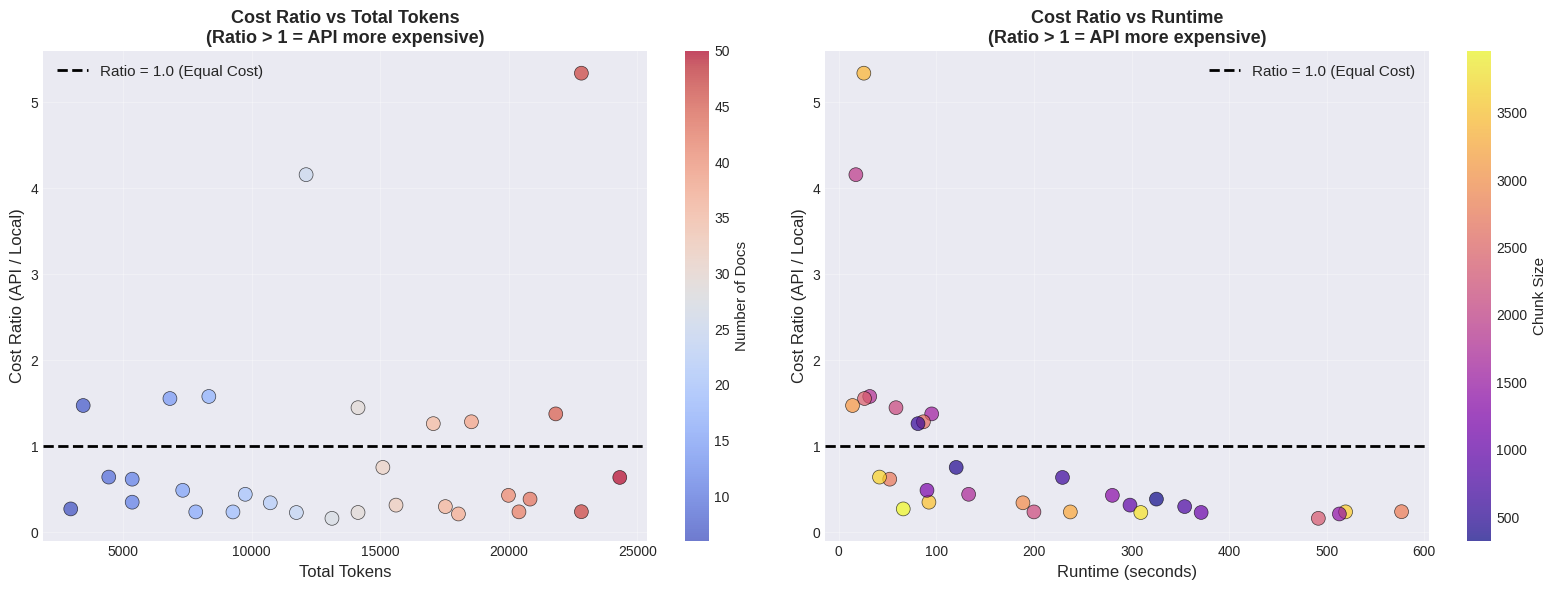

In [18]:
# d) Cost Ratio Analysis
# Scatter plot of cost ratio (API/Local) vs total tokens
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cost ratio vs Total Tokens
ax1 = axes[0]
scatter1 = ax1.scatter(
    summary_df['total_tokens'],
    summary_df['cost_ratio'],
    c=summary_df['num_docs'],
    cmap='coolwarm',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ratio = 1.0 (Equal Cost)')
ax1.set_xlabel('Total Tokens', fontsize=12)
ax1.set_ylabel('Cost Ratio (API / Local)', fontsize=12)
ax1.set_title('Cost Ratio vs Total Tokens\n(Ratio > 1 = API more expensive)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Number of Docs', fontsize=11)

# Plot 2: Cost ratio vs Runtime
ax2 = axes[1]
scatter2 = ax2.scatter(
    summary_df['total_runtime_seconds'],
    summary_df['cost_ratio'],
    c=summary_df['chunk_size'],
    cmap='plasma',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax2.axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='Ratio = 1.0 (Equal Cost)')
ax2.set_xlabel('Runtime (seconds)', fontsize=12)
ax2.set_ylabel('Cost Ratio (API / Local)', fontsize=12)
ax2.set_title('Cost Ratio vs Runtime\n(Ratio > 1 = API more expensive)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Chunk Size', fontsize=11)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_cost_ratio_analysis.png', dpi=150, bbox_inches='tight')
print(f"Saved cost ratio analysis to: {experiments_dir / 'nolh_cost_ratio_analysis.png'}")
plt.show()


Saved parameter space with cost difference to: results/experiments/nolh/nolh_parameter_space_cost_difference.png


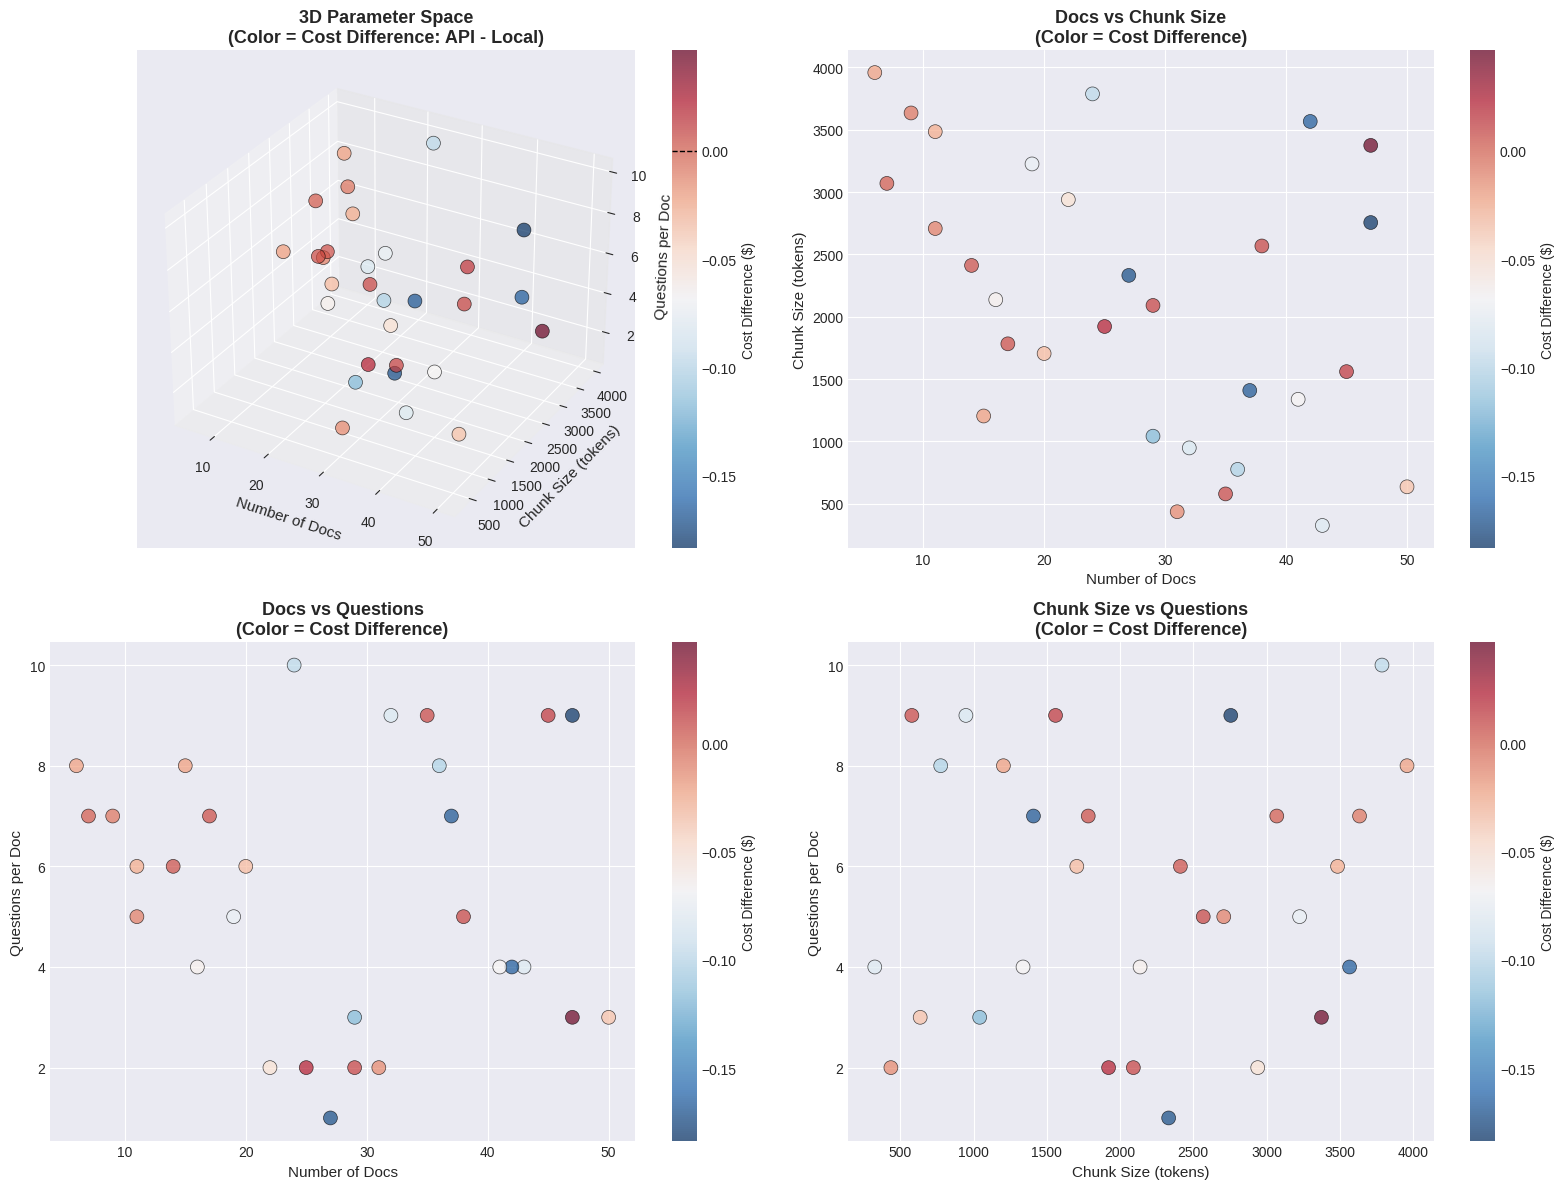

In [19]:
# e) Parameter Space with Cost Difference Coloring
# 3D scatter plot colored by cost difference (diverging colormap)
fig = plt.figure(figsize=(16, 12))

# Create 3D subplot
ax1 = fig.add_subplot(221, projection='3d')
# Use diverging colormap centered at 0
scatter = ax1.scatter(
    summary_df['num_docs'],
    summary_df['chunk_size'],
    summary_df['num_questions_per_doc'],
    c=summary_df['cost_difference'],
    cmap='RdBu_r',  # Red-Blue reversed: red = positive (API expensive), blue = negative (Local expensive)
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax1.set_xlabel('Number of Docs', fontsize=11)
ax1.set_ylabel('Chunk Size (tokens)', fontsize=11)
ax1.set_zlabel('Questions per Doc', fontsize=11)
ax1.set_title('3D Parameter Space\n(Color = Cost Difference: API - Local)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax1, label='Cost Difference ($)')
cbar.ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Pairwise plots with cost difference coloring
ax2 = fig.add_subplot(222)
scatter2 = ax2.scatter(
    summary_df['num_docs'],
    summary_df['chunk_size'],
    c=summary_df['cost_difference'],
    cmap='RdBu_r',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax2.set_xlabel('Number of Docs', fontsize=11)
ax2.set_ylabel('Chunk Size (tokens)', fontsize=11)
ax2.set_title('Docs vs Chunk Size\n(Color = Cost Difference)', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cost Difference ($)')

ax3 = fig.add_subplot(223)
scatter3 = ax3.scatter(
    summary_df['num_docs'],
    summary_df['num_questions_per_doc'],
    c=summary_df['cost_difference'],
    cmap='RdBu_r',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax3.set_xlabel('Number of Docs', fontsize=11)
ax3.set_ylabel('Questions per Doc', fontsize=11)
ax3.set_title('Docs vs Questions\n(Color = Cost Difference)', fontsize=13, fontweight='bold')
plt.colorbar(scatter3, ax=ax3, label='Cost Difference ($)')

ax4 = fig.add_subplot(224)
scatter4 = ax4.scatter(
    summary_df['chunk_size'],
    summary_df['num_questions_per_doc'],
    c=summary_df['cost_difference'],
    cmap='RdBu_r',
    s=100,
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5
)
ax4.set_xlabel('Chunk Size (tokens)', fontsize=11)
ax4.set_ylabel('Questions per Doc', fontsize=11)
ax4.set_title('Chunk Size vs Questions\n(Color = Cost Difference)', fontsize=13, fontweight='bold')
plt.colorbar(scatter4, ax=ax4, label='Cost Difference ($)')

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_parameter_space_cost_difference.png', dpi=150, bbox_inches='tight')
print(f"Saved parameter space with cost difference to: {experiments_dir / 'nolh_parameter_space_cost_difference.png'}")
plt.show()


Saved cost comparison by parameter to: results/experiments/nolh/nolh_cost_comparison_by_parameter.png


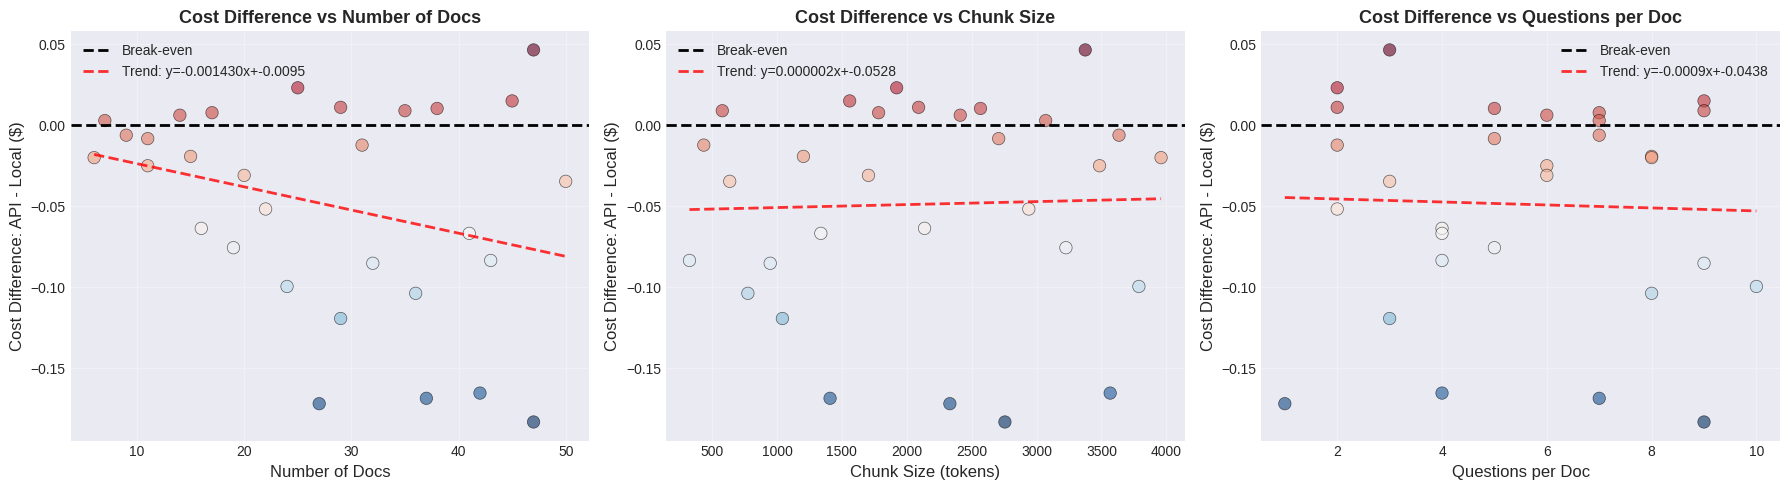

In [20]:
# f) Cost Comparison by Parameter
# Three subplots showing cost difference vs each parameter
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Cost difference vs Number of Docs
ax1 = axes[0]
scatter1 = ax1.scatter(summary_df['num_docs'], summary_df['cost_difference'], 
                       alpha=0.6, s=80, c=summary_df['cost_difference'], 
                       cmap='RdBu_r', edgecolors='black', linewidth=0.5)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Break-even')
ax1.set_xlabel('Number of Docs', fontsize=12)
ax1.set_ylabel('Cost Difference: API - Local ($)', fontsize=12)
ax1.set_title('Cost Difference vs Number of Docs', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(summary_df['num_docs'], summary_df['cost_difference'], 1)
p = np.poly1d(z)
ax1.plot(summary_df['num_docs'].sort_values(), 
         p(summary_df['num_docs'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.6f}x+{z[1]:.4f}')
ax1.legend(fontsize=10)

# Cost difference vs Chunk Size
ax2 = axes[1]
scatter2 = ax2.scatter(summary_df['chunk_size'], summary_df['cost_difference'], 
                       alpha=0.6, s=80, c=summary_df['cost_difference'], 
                       cmap='RdBu_r', edgecolors='black', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Break-even')
ax2.set_xlabel('Chunk Size (tokens)', fontsize=12)
ax2.set_ylabel('Cost Difference: API - Local ($)', fontsize=12)
ax2.set_title('Cost Difference vs Chunk Size', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(summary_df['chunk_size'], summary_df['cost_difference'], 1)
p = np.poly1d(z)
ax2.plot(summary_df['chunk_size'].sort_values(), 
         p(summary_df['chunk_size'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.6f}x+{z[1]:.4f}')
ax2.legend(fontsize=10)

# Cost difference vs Questions per Doc
ax3 = axes[2]
scatter3 = ax3.scatter(summary_df['num_questions_per_doc'], summary_df['cost_difference'], 
                      alpha=0.6, s=80, c=summary_df['cost_difference'], 
                      cmap='RdBu_r', edgecolors='black', linewidth=0.5)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Break-even')
ax3.set_xlabel('Questions per Doc', fontsize=12)
ax3.set_ylabel('Cost Difference: API - Local ($)', fontsize=12)
ax3.set_title('Cost Difference vs Questions per Doc', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
# Add trend line
z = np.polyfit(summary_df['num_questions_per_doc'], summary_df['cost_difference'], 1)
p = np.poly1d(z)
ax3.plot(summary_df['num_questions_per_doc'].sort_values(), 
         p(summary_df['num_questions_per_doc'].sort_values()), 
         "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
ax3.legend(fontsize=10)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_cost_comparison_by_parameter.png', dpi=150, bbox_inches='tight')
print(f"Saved cost comparison by parameter to: {experiments_dir / 'nolh_cost_comparison_by_parameter.png'}")
plt.show()


## Section 9: Statistical Analysis

Perform correlation analysis and parameter importance ranking to understand which parameters most affect cost, tokens, and runtime.


Correlation Analysis:
Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)
Values closer to 0 indicate weak or no correlation

Correlation Matrix:
Outcome                cost_api_per_1k_tokens  cost_api_total  \
Parameter                                                       
chunk_size                            -0.0293         -0.4385   
num_docs                               0.0590          1.0000   
num_questions_per_doc                  0.1363         -0.1224   

Outcome                cost_difference  cost_local_per_1k_tokens  \
Parameter                                                          
chunk_size                      0.0315                    0.1462   
num_docs                       -0.2940                    0.0103   
num_questions_per_doc          -0.0370                    0.0245   

Outcome                cost_local_total  cost_ratio  total_runtime_seconds  \
Parameter                                                               

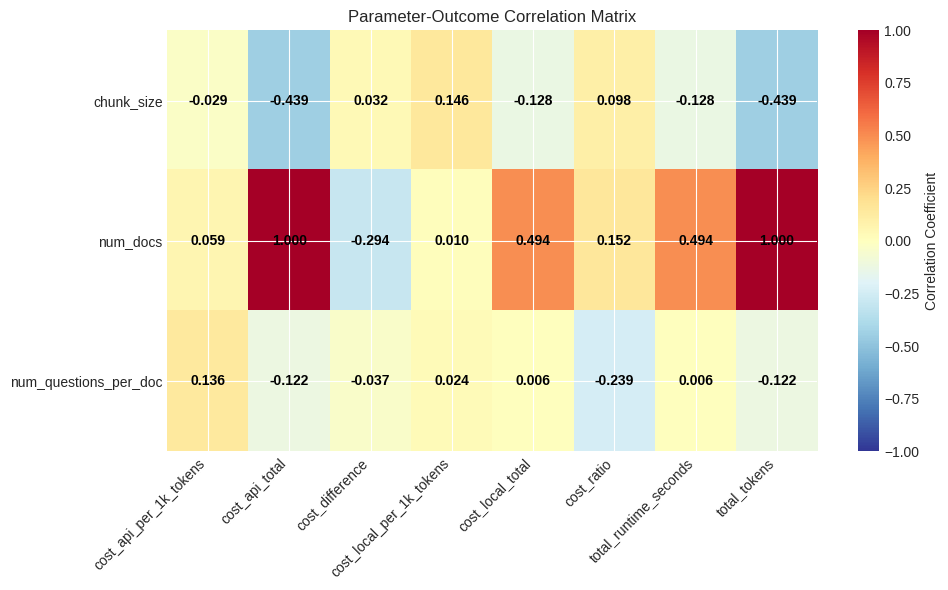

In [21]:
# Correlation Analysis
# Calculate correlation coefficients between parameters and outcomes
# This tells us which parameters are most strongly related to cost, tokens, and runtime

# Select parameter columns and outcome columns
# Now including both API and local costs, plus cost difference and ratio
parameter_cols = ['num_docs', 'chunk_size', 'num_questions_per_doc']
outcome_cols = ['cost_api_total', 'cost_local_total', 'cost_difference', 'cost_ratio', 
                'total_tokens', 'total_runtime_seconds', 'cost_api_per_1k_tokens', 'cost_local_per_1k_tokens']

# Calculate correlation matrix
correlation_data = []
for outcome in outcome_cols:
    for param in parameter_cols:
        corr = summary_df[param].corr(summary_df[outcome])
        correlation_data.append({
            'Parameter': param,
            'Outcome': outcome,
            'Correlation': corr
        })

correlation_df = pd.DataFrame(correlation_data)
correlation_pivot = correlation_df.pivot(index='Parameter', columns='Outcome', values='Correlation')

print("Correlation Analysis:")
print("=" * 80)
print("Values range from -1 (perfect negative correlation) to +1 (perfect positive correlation)")
print("Values closer to 0 indicate weak or no correlation")
print("\nCorrelation Matrix:")
print(correlation_pivot.round(4))

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(correlation_pivot.values, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(len(correlation_pivot.columns)))
ax.set_yticks(range(len(correlation_pivot.index)))
ax.set_xticklabels(correlation_pivot.columns, rotation=45, ha='right')
ax.set_yticklabels(correlation_pivot.index)
ax.set_title('Parameter-Outcome Correlation Matrix')

# Add text annotations
for i in range(len(correlation_pivot.index)):
    for j in range(len(correlation_pivot.columns)):
        text = ax.text(j, i, f'{correlation_pivot.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=ax, label='Correlation Coefficient')
plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_correlation_matrix.png', dpi=150, bbox_inches='tight')
print(f"\nSaved correlation matrix plot to: {experiments_dir / 'nolh_correlation_matrix.png'}")
plt.show()



Parameter Importance Ranking:

COST_API_TOTAL:
  1. num_docs: 1.0000 (increases cost_api_total)
  2. chunk_size: -0.4385 (decreases cost_api_total)
  3. num_questions_per_doc: -0.1224 (decreases cost_api_total)

COST_LOCAL_TOTAL:
  1. num_docs: 0.4940 (increases cost_local_total)
  2. chunk_size: -0.1281 (decreases cost_local_total)
  3. num_questions_per_doc: 0.0059 (increases cost_local_total)

COST_DIFFERENCE:
  1. num_docs: -0.2940 (decreases cost_difference)
  2. num_questions_per_doc: -0.0370 (decreases cost_difference)
  3. chunk_size: 0.0315 (increases cost_difference)

COST_RATIO:
  1. num_questions_per_doc: -0.2390 (decreases cost_ratio)
  2. num_docs: 0.1523 (increases cost_ratio)
  3. chunk_size: 0.0981 (increases cost_ratio)

TOTAL_TOKENS:
  1. num_docs: 1.0000 (increases total_tokens)
  2. chunk_size: -0.4385 (decreases total_tokens)
  3. num_questions_per_doc: -0.1224 (decreases total_tokens)

TOTAL_RUNTIME_SECONDS:
  1. num_docs: 0.4940 (increases total_runtime_seconds

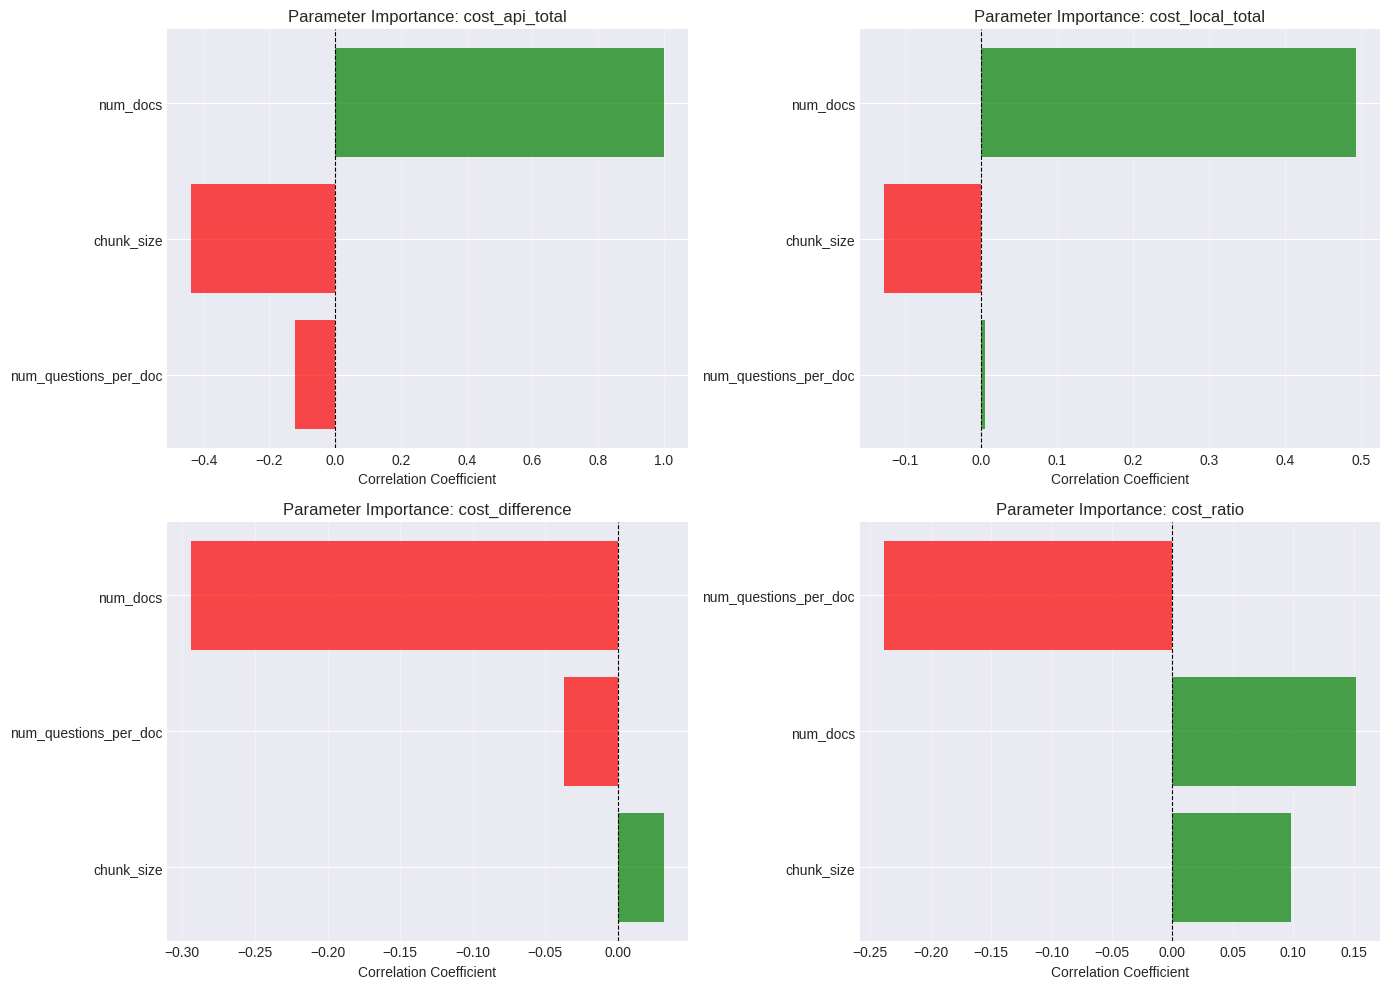

In [22]:
# Parameter Importance Ranking
# Rank parameters by their absolute correlation with key outcomes
# This helps identify which parameters have the biggest impact

importance_data = []

for outcome in outcome_cols:
    # Get correlations for this outcome
    outcome_corrs = correlation_df[correlation_df['Outcome'] == outcome].copy()
    outcome_corrs['Abs_Correlation'] = outcome_corrs['Correlation'].abs()
    outcome_corrs = outcome_corrs.sort_values('Abs_Correlation', ascending=False)
    
    # Rank parameters
    outcome_corrs['Rank'] = range(1, len(outcome_corrs) + 1)
    
    for _, row in outcome_corrs.iterrows():
        importance_data.append({
            'Outcome': outcome,
            'Parameter': row['Parameter'],
            'Correlation': row['Correlation'],
            'Abs_Correlation': row['Abs_Correlation'],
            'Rank': row['Rank']
        })

importance_df = pd.DataFrame(importance_data)

print("\nParameter Importance Ranking:")
print("=" * 80)
for outcome in outcome_cols:
    print(f"\n{outcome.upper()}:")
    outcome_importance = importance_df[importance_df['Outcome'] == outcome].sort_values('Rank')
    for _, row in outcome_importance.iterrows():
        direction = "increases" if row['Correlation'] > 0 else "decreases"
        print(f"  {row['Rank']}. {row['Parameter']}: {row['Correlation']:.4f} ({direction} {outcome})")

# Visualize importance rankings
# Create subplots for key outcomes (focusing on cost-related ones)
key_outcomes = ['cost_api_total', 'cost_local_total', 'cost_difference', 'cost_ratio']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, outcome in enumerate(key_outcomes):
    if idx >= len(axes):
        break
    ax = axes[idx]
    outcome_importance = importance_df[importance_df['Outcome'] == outcome].sort_values('Abs_Correlation', ascending=True)
    
    colors = ['green' if c > 0 else 'red' for c in outcome_importance['Correlation']]
    ax.barh(outcome_importance['Parameter'], outcome_importance['Correlation'], color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_title(f'Parameter Importance: {outcome}')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_parameter_importance.png', dpi=150, bbox_inches='tight')
print(f"\nSaved parameter importance plot to: {experiments_dir / 'nolh_parameter_importance.png'}")
plt.show()


### Cost Comparison Summary Statistics

Calculate and display summary statistics comparing API vs Local pricing models.


In [23]:
# Summary Statistics: API vs Local Cost Comparison
print("=" * 80)
print("API vs Local Cost Comparison Summary Statistics")
print("=" * 80)

# Calculate key statistics
api_mean = summary_df['cost_api_total'].mean()
api_median = summary_df['cost_api_total'].median()
api_std = summary_df['cost_api_total'].std()
api_min = summary_df['cost_api_total'].min()
api_max = summary_df['cost_api_total'].max()

local_mean = summary_df['cost_local_total'].mean()
local_median = summary_df['cost_local_total'].median()
local_std = summary_df['cost_local_total'].std()
local_min = summary_df['cost_local_total'].min()
local_max = summary_df['cost_local_total'].max()

diff_mean = summary_df['cost_difference'].mean()
diff_median = summary_df['cost_difference'].median()
ratio_mean = summary_df['cost_ratio'].mean()
ratio_median = summary_df['cost_ratio'].median()

# Count experiments where each pricing model is cheaper
api_cheaper = (summary_df['cost_difference'] < 0).sum()
local_cheaper = (summary_df['cost_difference'] > 0).sum()
equal = (summary_df['cost_difference'] == 0).sum()
total = len(summary_df)

print(f"\n1. Total Cost Statistics:")
print(f"   API Pricing:")
print(f"     Mean:   ${api_mean:.4f}")
print(f"     Median: ${api_median:.4f}")
print(f"     Std Dev: ${api_std:.4f}")
print(f"     Range:  ${api_min:.4f} - ${api_max:.4f}")
print(f"   Local Pricing:")
print(f"     Mean:   ${local_mean:.4f}")
print(f"     Median: ${local_median:.4f}")
print(f"     Std Dev: ${local_std:.4f}")
print(f"     Range:  ${local_min:.4f} - ${local_max:.4f}")

print(f"\n2. Cost Difference (API - Local):")
print(f"   Mean:   ${diff_mean:.4f}")
print(f"   Median: ${diff_median:.4f}")
print(f"   (Positive = API more expensive, Negative = Local more expensive)")

print(f"\n3. Cost Ratio (API / Local):")
print(f"   Mean:   {ratio_mean:.3f}x")
print(f"   Median: {ratio_median:.3f}x")
print(f"   (Ratio > 1 = API more expensive, Ratio < 1 = Local more expensive)")

print(f"\n4. Pricing Model Comparison:")
print(f"   API Cheaper:  {api_cheaper} experiments ({api_cheaper/total*100:.1f}%)")
print(f"   Local Cheaper: {local_cheaper} experiments ({local_cheaper/total*100:.1f}%)")
print(f"   Equal Cost:   {equal} experiments ({equal/total*100:.1f}%)")

# Calculate savings
if api_cheaper > 0:
    api_savings = summary_df[summary_df['cost_difference'] < 0]['cost_difference'].abs().sum()
    print(f"\n5. Potential Savings:")
    print(f"   If using API when cheaper: ${api_savings:.4f} total savings")
    
if local_cheaper > 0:
    local_savings = summary_df[summary_df['cost_difference'] > 0]['cost_difference'].sum()
    print(f"   If using Local when cheaper: ${local_savings:.4f} total savings")

# Find parameter ranges where each pricing model is optimal
print(f"\n6. Optimal Pricing Model by Parameter Ranges:")

# By num_docs
api_optimal_docs = summary_df[summary_df['cost_difference'] < 0]['num_docs']
local_optimal_docs = summary_df[summary_df['cost_difference'] > 0]['num_docs']
if len(api_optimal_docs) > 0:
    print(f"   API optimal when num_docs: {api_optimal_docs.min():.0f} - {api_optimal_docs.max():.0f} (mean: {api_optimal_docs.mean():.1f})")
if len(local_optimal_docs) > 0:
    print(f"   Local optimal when num_docs: {local_optimal_docs.min():.0f} - {local_optimal_docs.max():.0f} (mean: {local_optimal_docs.mean():.1f})")

# By chunk_size
api_optimal_chunk = summary_df[summary_df['cost_difference'] < 0]['chunk_size']
local_optimal_chunk = summary_df[summary_df['cost_difference'] > 0]['chunk_size']
if len(api_optimal_chunk) > 0:
    print(f"   API optimal when chunk_size: {api_optimal_chunk.min():.0f} - {api_optimal_chunk.max():.0f} (mean: {api_optimal_chunk.mean():.1f})")
if len(local_optimal_chunk) > 0:
    print(f"   Local optimal when chunk_size: {local_optimal_chunk.min():.0f} - {local_optimal_chunk.max():.0f} (mean: {local_optimal_chunk.mean():.1f})")

# By num_questions
api_optimal_q = summary_df[summary_df['cost_difference'] < 0]['num_questions_per_doc']
local_optimal_q = summary_df[summary_df['cost_difference'] > 0]['num_questions_per_doc']
if len(api_optimal_q) > 0:
    print(f"   API optimal when num_questions: {api_optimal_q.min():.0f} - {api_optimal_q.max():.0f} (mean: {api_optimal_q.mean():.1f})")
if len(local_optimal_q) > 0:
    print(f"   Local optimal when num_questions: {local_optimal_q.min():.0f} - {local_optimal_q.max():.0f} (mean: {local_optimal_q.mean():.1f})")

print("\n" + "=" * 80)


API vs Local Cost Comparison Summary Statistics

1. Total Cost Statistics:
   API Pricing:
     Mean:   $0.0335
     Median: $0.0341
     Std Dev: $0.0161
     Range:  $0.0074 - $0.0608
   Local Pricing:
     Mean:   $0.0823
     Median: $0.0528
     Std Dev: $0.0709
     Range:  $0.0059 - $0.2403

2. Cost Difference (API - Local):
   Mean:   $-0.0488
   Median: $-0.0281
   (Positive = API more expensive, Negative = Local more expensive)

3. Cost Ratio (API / Local):
   Mean:   0.907x
   Median: 0.434x
   (Ratio > 1 = API more expensive, Ratio < 1 = Local more expensive)

4. Pricing Model Comparison:
   API Cheaper:  21 experiments (70.0%)
   Local Cheaper: 9 experiments (30.0%)
   Equal Cost:   0 experiments (0.0%)

5. Potential Savings:
   If using API when cheaper: $1.5963 total savings
   If using Local when cheaper: $0.1308 total savings

6. Optimal Pricing Model by Parameter Ranges:
   API optimal when num_docs: 6 - 50 (mean: 27.0)
   Local optimal when num_docs: 7 - 47 (mean: 28

## Section 10: NOLH Validation

Validate the NOLH design by showing sample distribution and verifying space-filling properties.


Saved sample distribution plot to: results/experiments/nolh/nolh_sample_distribution.png


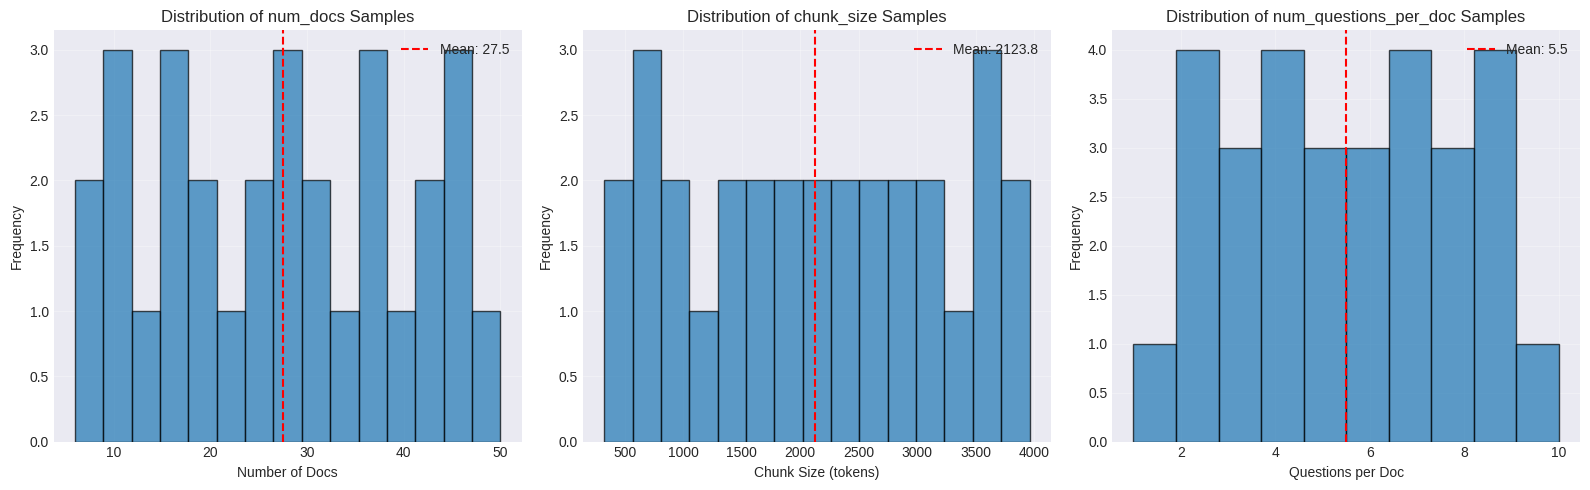

In [24]:
# Visualize sample distribution across parameter space
# This validates that our NOLH samples are well-distributed

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histogram of num_docs distribution
ax1 = axes[0]
ax1.hist(summary_df['num_docs'], bins=15, edgecolor='black', alpha=0.7)
ax1.axvline(summary_df['num_docs'].mean(), color='red', linestyle='--', 
           label=f'Mean: {summary_df["num_docs"].mean():.1f}')
ax1.set_xlabel('Number of Docs')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of num_docs Samples')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram of chunk_size distribution
ax2 = axes[1]
ax2.hist(summary_df['chunk_size'], bins=15, edgecolor='black', alpha=0.7)
ax2.axvline(summary_df['chunk_size'].mean(), color='red', linestyle='--', 
           label=f'Mean: {summary_df["chunk_size"].mean():.1f}')
ax2.set_xlabel('Chunk Size (tokens)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of chunk_size Samples')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Histogram of num_questions_per_doc distribution
ax3 = axes[2]
ax3.hist(summary_df['num_questions_per_doc'], bins=10, edgecolor='black', alpha=0.7)
ax3.axvline(summary_df['num_questions_per_doc'].mean(), color='red', linestyle='--', 
           label=f'Mean: {summary_df["num_questions_per_doc"].mean():.1f}')
ax3.set_xlabel('Questions per Doc')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of num_questions_per_doc Samples')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(experiments_dir / 'nolh_sample_distribution.png', dpi=150, bbox_inches='tight')
print(f"Saved sample distribution plot to: {experiments_dir / 'nolh_sample_distribution.png'}")
plt.show()


In [33]:
# Calculate coverage metrics
# These metrics validate that our samples cover the parameter space well

def calculate_coverage_metrics(df, param_col, param_range):
    """Calculate coverage metrics for a parameter."""
    min_val, max_val = param_range
    range_size = max_val - min_val
    
    # Calculate how well the range is covered
    actual_min = df[param_col].min()
    actual_max = df[param_col].max()
    actual_range = actual_max - actual_min
    range_coverage = (actual_range / range_size) * 100 if range_size > 0 else 0
    
    # Calculate spacing (average distance between consecutive sorted values)
    sorted_vals = sorted(df[param_col].unique())
    if len(sorted_vals) > 1:
        spacings = [sorted_vals[i+1] - sorted_vals[i] for i in range(len(sorted_vals)-1)]
        avg_spacing = np.mean(spacings)
        ideal_spacing = range_size / (len(sorted_vals) - 1) if len(sorted_vals) > 1 else 0
        spacing_efficiency = (ideal_spacing / avg_spacing * 100) if avg_spacing > 0 else 0
    else:
        avg_spacing = 0
        spacing_efficiency = 0
    
    return {
        'parameter': param_col,
        'min_value': actual_min,
        'max_value': actual_max,
        'range_coverage_pct': range_coverage,
        'unique_values': len(sorted_vals),
        'avg_spacing': avg_spacing,
        'spacing_efficiency_pct': spacing_efficiency
    }

# Calculate coverage for each parameter
# Map parameter names from parameter_ranges to actual column names in summary_df
# Note: gen_model_idx and embed_model_idx are discrete indices, not continuous parameters
# so we skip them for coverage analysis (they represent model selection, not numeric ranges)
param_column_mapping = {
    'num_docs': 'num_docs',
    'chunk_size': 'chunk_size',
    'num_questions_per_doc': 'num_questions_per_doc',
    # Skip gen_model_idx and embed_model_idx - these are discrete model indices
    # They don't have corresponding numeric columns in summary_df for range coverage
}

coverage_metrics = []
for param, param_range in parameter_ranges.items():
    # Skip discrete parameters (model indices) - they can't be analyzed for range coverage
    if param in ['gen_model_idx', 'embed_model_idx']:
        continue
    
    # Get the actual column name in summary_df
    if param in param_column_mapping:
        actual_col = param_column_mapping[param]
        
        # Check if column exists in summary_df
        if actual_col in summary_df.columns:
            metrics = calculate_coverage_metrics(summary_df, actual_col, param_range)
            coverage_metrics.append(metrics)
        else:
            print(f"⚠️  Warning: Column '{actual_col}' not found in summary_df. Skipping coverage analysis for '{param}'.")
    else:
        print(f"⚠️  Warning: Parameter '{param}' not in mapping. Skipping coverage analysis.")

coverage_df = pd.DataFrame(coverage_metrics)

print("NOLH Design Coverage Metrics:")
print("=" * 80)
print("\nThese metrics validate that our samples are well-distributed:")
print("  - Range Coverage: % of parameter range actually covered by samples")
print("  - Unique Values: Number of distinct values sampled")
print("  - Spacing Efficiency: How evenly spaced the samples are (100% = perfectly even)")
print("\nCoverage Summary:")
print(coverage_df.to_string(index=False))

# Calculate overall design quality score
# This is a simple metric combining coverage and spacing
overall_quality = (
    coverage_df['range_coverage_pct'].mean() * 0.5 +
    coverage_df['spacing_efficiency_pct'].mean() * 0.5
)

print(f"\nOverall Design Quality Score: {overall_quality:.2f}%")
print("(Higher is better - indicates good space-filling properties)")


NOLH Design Coverage Metrics:

These metrics validate that our samples are well-distributed:
  - Range Coverage: % of parameter range actually covered by samples
  - Unique Values: Number of distinct values sampled
  - Spacing Efficiency: How evenly spaced the samples are (100% = perfectly even)

Coverage Summary:
            parameter  min_value  max_value  range_coverage_pct  unique_values  avg_spacing  spacing_efficiency_pct
             num_docs          6         50           97.777778             27     1.692308              102.272727
           chunk_size        326       3959           97.035256             30   125.275862              103.055326
num_questions_per_doc          1         10          100.000000             10     1.000000              100.000000

Overall Design Quality Score: 100.02%
(Higher is better - indicates good space-filling properties)


## Section 10: CSV Exports

Export all important data to CSV files for easy analysis in Excel, Google Sheets, or other tools.

This section creates multiple CSV files with different views of the experimental data:
1. **Full Experiment Summary** - Complete results from all experiments
2. **Coverage Metrics** - NOLH design quality metrics
3. **Model Performance Comparison** - Aggregated metrics by model
4. **Cost Analysis Summary** - Cost breakdowns and comparisons
5. **Parameter Sensitivity** - How parameters affect costs and performance


In [38]:
# ============================================================================
# CSV Export Section
# ============================================================================
# Export all important data to CSV files for spreadsheet analysis
# Each CSV file focuses on a different aspect of the experimental results

from datetime import datetime
import os

# Get current timestamp for export metadata and filenames
export_timestamp = datetime.now().isoformat()
export_timestamp_readable = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Timestamp for filenames (format: YYYYMMDD_HHMMSS)
experiment_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create timestamped exports directory if it doesn't exist
# Use the same experiment_timestamp for consistency
exports_dir = experiments_dir / f"csv_exports_{experiment_timestamp}"
exports_dir.mkdir(exist_ok=True)

# Get current timestamp for export metadata and filenames
export_timestamp = datetime.now().isoformat()
export_timestamp_readable = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Timestamp for filenames (format: YYYYMMDD_HHMMSS)
export_timestamp_filename = datetime.now().strftime("%Y%m%d_%H%M%S")

print("=" * 80)
print("CSV Export Section")
print("=" * 80)
print(f"Export timestamp: {export_timestamp_readable}")
print(f"Export timestamp (filename): {export_timestamp_filename}")
print(f"Export directory: {exports_dir}")
print()


CSV Export Section
Export timestamp: 2025-11-23 16:47:59
Export timestamp (filename): 20251123_164759
Export directory: results/experiments/nolh/csv_exports_20251123_164759



### 1. Full Experiment Summary

Complete results from all experiments with all metrics and costs.


In [39]:
# 1. Full Experiment Summary
# This is the complete dataset with all experiment results
# Includes all metrics, costs, and configuration parameters

# Ensure summary_df exists and has data
if 'summary_df' in locals() and not summary_df.empty:
    # Add export timestamp column
    summary_df_export = summary_df.copy()
    summary_df_export['export_timestamp'] = export_timestamp
    summary_df_export['export_timestamp_readable'] = export_timestamp_readable
    
    # Reorder columns to put timestamps first (if they exist)
    if 'experiment_timestamp' in summary_df_export.columns:
        cols = ['experiment_timestamp', 'experiment_timestamp_readable', 'export_timestamp', 'export_timestamp_readable'] + \
               [c for c in summary_df_export.columns if c not in ['experiment_timestamp', 'experiment_timestamp_readable', 'export_timestamp', 'export_timestamp_readable']]
        summary_df_export = summary_df_export[cols]
    else:
        cols = ['export_timestamp', 'export_timestamp_readable'] + \
               [c for c in summary_df_export.columns if c not in ['export_timestamp', 'export_timestamp_readable']]
        summary_df_export = summary_df_export[cols]
    
    # Save to CSV with timestamp
    full_summary_path = exports_dir / f"01_full_experiment_summary_{export_timestamp_filename}.csv"
    summary_df_export.to_csv(full_summary_path, index=False)
    print(f"✅ 1. Full Experiment Summary")
    print(f"   File: {full_summary_path.name}")
    print(f"   Rows: {len(summary_df_export)}, Columns: {len(summary_df_export.columns)}")
    print()
else:
    print("⚠️  summary_df not available. Run experiment execution section first.")
    print()


✅ 1. Full Experiment Summary
   File: 01_full_experiment_summary_20251123_164759.csv
   Rows: 30, Columns: 40



### 2. Coverage Metrics

NOLH design quality metrics showing how well the parameter space was covered.


In [40]:
# 2. Coverage Metrics
# NOLH design quality metrics

if 'coverage_df' in locals() and not coverage_df.empty:
    coverage_df_export = coverage_df.copy()
    coverage_df_export['export_timestamp'] = export_timestamp
    coverage_df_export['export_timestamp_readable'] = export_timestamp_readable
    
    # Reorder columns
    cols = ['export_timestamp', 'export_timestamp_readable'] + \
           [c for c in coverage_df_export.columns if c not in ['export_timestamp', 'export_timestamp_readable']]
    coverage_df_export = coverage_df_export[cols]
    
    coverage_path = exports_dir / f"02_nolh_coverage_metrics_{export_timestamp_filename}.csv"
    coverage_df_export.to_csv(coverage_path, index=False)
    print(f"✅ 2. Coverage Metrics")
    print(f"   File: {coverage_path.name}")
    print(f"   Rows: {len(coverage_df_export)}, Columns: {len(coverage_df_export.columns)}")
    print()
else:
    print("⚠️  coverage_df not available. Run coverage analysis section first.")
    print()


✅ 2. Coverage Metrics
   File: 02_nolh_coverage_metrics_20251123_164759.csv
   Rows: 3, Columns: 9



### 3. Model Performance Comparison

Aggregated performance metrics grouped by generation and embedding models.


In [41]:
# 3. Model Performance Comparison
# Aggregate metrics by generation model and embedding model

if 'summary_df' in locals() and not summary_df.empty:
    # Group by generation model
    gen_model_stats = summary_df.groupby('gen_model').agg({
        'total_tokens': ['count', 'mean', 'sum'],
        'total_runtime_seconds': ['mean', 'sum'],
        'tokens_per_second': 'mean',
        'cost_api_total': ['mean', 'sum', 'min', 'max'],
        'cost_local_total': ['mean', 'sum', 'min', 'max'],
        'cost_difference': 'mean',
        'cost_ratio': 'mean'
    }).round(4)
    
    # Flatten column names
    gen_model_stats.columns = ['_'.join(col).strip() for col in gen_model_stats.columns.values]
    gen_model_stats = gen_model_stats.reset_index()
    gen_model_stats['export_timestamp'] = export_timestamp
    gen_model_stats['export_timestamp_readable'] = export_timestamp_readable
    
    # Reorder columns
    cols = ['export_timestamp', 'export_timestamp_readable', 'gen_model'] + \
           [c for c in gen_model_stats.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'gen_model']]
    gen_model_stats = gen_model_stats[cols]
    
    gen_model_path = exports_dir / f"03_model_performance_by_gen_model_{export_timestamp_filename}.csv"
    gen_model_stats.to_csv(gen_model_path, index=False)
    print(f"✅ 3a. Generation Model Performance")
    print(f"   File: {gen_model_path.name}")
    print(f"   Rows: {len(gen_model_stats)}, Columns: {len(gen_model_stats.columns)}")
    
    # Group by embedding model
    embed_model_stats = summary_df.groupby('embed_model').agg({
        'total_tokens': ['count', 'mean', 'sum'],
        'total_runtime_seconds': ['mean', 'sum'],
        'tokens_per_second': 'mean',
        'cost_api_total': ['mean', 'sum', 'min', 'max'],
        'cost_local_total': ['mean', 'sum', 'min', 'max'],
        'cost_difference': 'mean',
        'cost_ratio': 'mean'
    }).round(4)
    
    # Flatten column names
    embed_model_stats.columns = ['_'.join(col).strip() for col in embed_model_stats.columns.values]
    embed_model_stats = embed_model_stats.reset_index()
    embed_model_stats['export_timestamp'] = export_timestamp
    embed_model_stats['export_timestamp_readable'] = export_timestamp_readable
    
    # Reorder columns
    cols = ['export_timestamp', 'export_timestamp_readable', 'embed_model'] + \
           [c for c in embed_model_stats.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'embed_model']]
    embed_model_stats = embed_model_stats[cols]
    
    embed_model_path = exports_dir / f"03_model_performance_by_embed_model_{export_timestamp_filename}.csv"
    embed_model_stats.to_csv(embed_model_path, index=False)
    print(f"✅ 3b. Embedding Model Performance")
    print(f"   File: {embed_model_path.name}")
    print(f"   Rows: {len(embed_model_stats)}, Columns: {len(embed_model_stats.columns)}")
    
    # Group by model combination
    model_combo_stats = summary_df.groupby(['gen_model', 'embed_model']).agg({
        'total_tokens': ['count', 'mean', 'sum'],
        'total_runtime_seconds': ['mean', 'sum'],
        'tokens_per_second': 'mean',
        'cost_api_total': ['mean', 'sum', 'min', 'max'],
        'cost_local_total': ['mean', 'sum', 'min', 'max'],
        'cost_difference': 'mean',
        'cost_ratio': 'mean'
    }).round(4)
    
    # Flatten column names
    model_combo_stats.columns = ['_'.join(col).strip() for col in model_combo_stats.columns.values]
    model_combo_stats = model_combo_stats.reset_index()
    model_combo_stats['export_timestamp'] = export_timestamp
    model_combo_stats['export_timestamp_readable'] = export_timestamp_readable
    
    # Reorder columns
    cols = ['export_timestamp', 'export_timestamp_readable', 'gen_model', 'embed_model'] + \
           [c for c in model_combo_stats.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'gen_model', 'embed_model']]
    model_combo_stats = model_combo_stats[cols]
    
    model_combo_path = exports_dir / f"03_model_performance_by_combination_{export_timestamp_filename}.csv"
    model_combo_stats.to_csv(model_combo_path, index=False)
    print(f"✅ 3c. Model Combination Performance")
    print(f"   File: {model_combo_path.name}")
    print(f"   Rows: {len(model_combo_stats)}, Columns: {len(model_combo_stats.columns)}")
    print()
else:
    print("⚠️  summary_df not available. Run experiment execution section first.")
    print()


✅ 3a. Generation Model Performance
   File: 03_model_performance_by_gen_model_20251123_164759.csv
   Rows: 7, Columns: 19
✅ 3b. Embedding Model Performance
   File: 03_model_performance_by_embed_model_20251123_164759.csv
   Rows: 4, Columns: 19
✅ 3c. Model Combination Performance
   File: 03_model_performance_by_combination_20251123_164759.csv
   Rows: 18, Columns: 20



### 4. Cost Analysis Summary

Detailed cost breakdowns comparing API vs local pricing models.


In [42]:
# 4. Cost Analysis Summary
# Detailed cost comparisons and breakdowns

if 'summary_df' in locals() and not summary_df.empty and 'cost_api_total' in summary_df.columns:
    # Create cost comparison summary
    cost_summary = {
        'export_timestamp': [export_timestamp],
        'export_timestamp_readable': [export_timestamp_readable],
        'total_experiments': [len(summary_df)],
        # API costs
        'api_total_cost_sum': [summary_df['cost_api_total'].sum()],
        'api_total_cost_mean': [summary_df['cost_api_total'].mean()],
        'api_total_cost_min': [summary_df['cost_api_total'].min()],
        'api_total_cost_max': [summary_df['cost_api_total'].max()],
        'api_cost_per_1k_tokens_mean': [summary_df['cost_api_per_1k_tokens'].mean()],
        # Local costs
        'local_total_cost_sum': [summary_df['cost_local_total'].sum()],
        'local_total_cost_mean': [summary_df['cost_local_total'].mean()],
        'local_total_cost_min': [summary_df['cost_local_total'].min()],
        'local_total_cost_max': [summary_df['cost_local_total'].max()],
        'local_cost_per_1k_tokens_mean': [summary_df['cost_local_per_1k_tokens'].mean()],
        # Cost comparison
        'cost_difference_mean': [summary_df['cost_difference'].mean()],
        'cost_difference_sum': [summary_df['cost_difference'].sum()],
        'cost_ratio_mean': [summary_df['cost_ratio'].mean()],
        'api_cheaper_count': [(summary_df['cost_difference'] < 0).sum()],
        'local_cheaper_count': [(summary_df['cost_difference'] > 0).sum()],
        'api_cheaper_pct': [(summary_df['cost_difference'] < 0).sum() / len(summary_df) * 100],
        'local_cheaper_pct': [(summary_df['cost_difference'] > 0).sum() / len(summary_df) * 100]
    }
    
    cost_summary_df = pd.DataFrame(cost_summary)
    cost_summary_path = exports_dir / f"04_cost_analysis_summary_{export_timestamp_filename}.csv"
    cost_summary_df.to_csv(cost_summary_path, index=False)
    print(f"✅ 4a. Cost Analysis Summary")
    print(f"   File: {cost_summary_path.name}")
    print(f"   Rows: {len(cost_summary_df)}, Columns: {len(cost_summary_df.columns)}")
    
    # Cost breakdown by parameter ranges
    # Group by num_docs ranges
    summary_df['num_docs_range'] = pd.cut(summary_df['num_docs'], 
                                         bins=[0, 10, 20, 30, 40, 50, 100],
                                         labels=['1-10', '11-20', '21-30', '31-40', '41-50', '50+'])
    
    cost_by_docs = summary_df.groupby('num_docs_range').agg({
        'cost_api_total': ['mean', 'sum', 'count'],
        'cost_local_total': ['mean', 'sum'],
        'cost_difference': 'mean',
        'cost_ratio': 'mean'
    }).round(4)
    cost_by_docs.columns = ['_'.join(col).strip() for col in cost_by_docs.columns.values]
    cost_by_docs = cost_by_docs.reset_index()
    cost_by_docs['export_timestamp'] = export_timestamp
    cost_by_docs['export_timestamp_readable'] = export_timestamp_readable
    
    cols = ['export_timestamp', 'export_timestamp_readable', 'num_docs_range'] + \
           [c for c in cost_by_docs.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'num_docs_range']]
    cost_by_docs = cost_by_docs[cols]
    
    cost_by_docs_path = exports_dir / f"04_cost_by_num_docs_{export_timestamp_filename}.csv"
    cost_by_docs.to_csv(cost_by_docs_path, index=False)
    print(f"✅ 4b. Cost by Number of Documents")
    print(f"   File: {cost_by_docs_path.name}")
    
    # Group by chunk_size ranges
    summary_df['chunk_size_range'] = pd.cut(summary_df['chunk_size'],
                                           bins=[0, 500, 1000, 2000, 3000, 4000, 5000],
                                           labels=['0-500', '501-1000', '1001-2000', '2001-3000', '3001-4000', '4000+'])
    
    cost_by_chunk = summary_df.groupby('chunk_size_range').agg({
        'cost_api_total': ['mean', 'sum', 'count'],
        'cost_local_total': ['mean', 'sum'],
        'cost_difference': 'mean',
        'cost_ratio': 'mean'
    }).round(4)
    cost_by_chunk.columns = ['_'.join(col).strip() for col in cost_by_chunk.columns.values]
    cost_by_chunk = cost_by_chunk.reset_index()
    cost_by_chunk['export_timestamp'] = export_timestamp
    cost_by_chunk['export_timestamp_readable'] = export_timestamp_readable
    
    cols = ['export_timestamp', 'export_timestamp_readable', 'chunk_size_range'] + \
           [c for c in cost_by_chunk.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'chunk_size_range']]
    cost_by_chunk = cost_by_chunk[cols]
    
    cost_by_chunk_path = exports_dir / f"04_cost_by_chunk_size_{export_timestamp_filename}.csv"
    cost_by_chunk.to_csv(cost_by_chunk_path, index=False)
    print(f"✅ 4c. Cost by Chunk Size")
    print(f"   File: {cost_by_chunk_path.name}")
    print()
else:
    print("⚠️  summary_df not available or missing cost columns. Run experiment execution section first.")
    print()


✅ 4a. Cost Analysis Summary
   File: 04_cost_analysis_summary_20251123_164759.csv
   Rows: 1, Columns: 20
✅ 4b. Cost by Number of Documents
   File: 04_cost_by_num_docs_20251123_164759.csv
✅ 4c. Cost by Chunk Size
   File: 04_cost_by_chunk_size_20251123_164759.csv



/tmp/ipykernel_200921/3055131858.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cost_by_docs = summary_df.groupby('num_docs_range').agg({
/tmp/ipykernel_200921/3055131858.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cost_by_chunk = summary_df.groupby('chunk_size_range').agg({


### 5. Parameter Sensitivity Analysis

How different parameters affect costs, performance, and token usage.


In [43]:
# 5. Parameter Sensitivity Analysis
# Analyze how parameters affect costs and performance

if 'summary_df' in locals() and not summary_df.empty:
    # Calculate correlations between parameters and outcomes
    numeric_cols = ['num_docs', 'chunk_size', 'num_questions_per_doc', 
                    'total_tokens', 'total_runtime_seconds', 'tokens_per_second',
                    'cost_api_total', 'cost_local_total', 'cost_difference', 'cost_ratio']
    
    # Filter to only columns that exist
    available_cols = [c for c in numeric_cols if c in summary_df.columns]
    correlation_df = summary_df[available_cols].corr()
    
    # Add export timestamp
    correlation_df['export_timestamp'] = export_timestamp
    correlation_df['export_timestamp_readable'] = export_timestamp_readable
    correlation_df = correlation_df.reset_index()
    correlation_df.rename(columns={'index': 'parameter'}, inplace=True)
    
    # Reorder columns
    cols = ['export_timestamp', 'export_timestamp_readable', 'parameter'] + \
           [c for c in correlation_df.columns if c not in ['export_timestamp', 'export_timestamp_readable', 'parameter']]
    correlation_df = correlation_df[cols]
    
    correlation_path = exports_dir / f"05_parameter_correlations_{export_timestamp_filename}.csv"
    correlation_df.to_csv(correlation_path, index=False)
    print(f"✅ 5a. Parameter Correlations")
    print(f"   File: {correlation_path.name}")
    print(f"   Shows how parameters correlate with costs and performance")
    
    # Parameter impact summary
    param_impact = []
    
    for param in ['num_docs', 'chunk_size', 'num_questions_per_doc']:
        if param in summary_df.columns:
            # Calculate how this parameter affects costs
            param_corr_cost_api = summary_df[param].corr(summary_df['cost_api_total']) if 'cost_api_total' in summary_df.columns else 0
            param_corr_cost_local = summary_df[param].corr(summary_df['cost_local_total']) if 'cost_local_total' in summary_df.columns else 0
            param_corr_tokens = summary_df[param].corr(summary_df['total_tokens']) if 'total_tokens' in summary_df.columns else 0
            param_corr_runtime = summary_df[param].corr(summary_df['total_runtime_seconds']) if 'total_runtime_seconds' in summary_df.columns else 0
            
            param_impact.append({
                'export_timestamp': export_timestamp,
                'export_timestamp_readable': export_timestamp_readable,
                'parameter': param,
                'correlation_with_cost_api': round(param_corr_cost_api, 4),
                'correlation_with_cost_local': round(param_corr_cost_local, 4),
                'correlation_with_total_tokens': round(param_corr_tokens, 4),
                'correlation_with_runtime': round(param_corr_runtime, 4),
                'parameter_min': summary_df[param].min(),
                'parameter_max': summary_df[param].max(),
                'parameter_mean': round(summary_df[param].mean(), 2)
            })
    
    param_impact_df = pd.DataFrame(param_impact)
    param_impact_path = exports_dir / f"05_parameter_impact_{export_timestamp_filename}.csv"
    param_impact_df.to_csv(param_impact_path, index=False)
    print(f"✅ 5b. Parameter Impact Analysis")
    print(f"   File: {param_impact_path.name}")
    print()
else:
    print("⚠️  summary_df not available. Run experiment execution section first.")
    print()


✅ 5a. Parameter Correlations
   File: 05_parameter_correlations_20251123_164759.csv
   Shows how parameters correlate with costs and performance
✅ 5b. Parameter Impact Analysis
   File: 05_parameter_impact_20251123_164759.csv



### 6. Export Summary

Summary of all exported files.


In [44]:
# 6. Export Summary
# List all exported CSV files with their details

print("=" * 80)
print("CSV Export Summary")
print("=" * 80)
print()

# List all CSV files in exports directory
csv_files = sorted(exports_dir.glob("*.csv"))

if csv_files:
    print(f"✅ Successfully exported {len(csv_files)} CSV files:")
    print()
    
    for i, csv_file in enumerate(csv_files, 1):
        # Get file size
        file_size = csv_file.stat().st_size
        file_size_kb = file_size / 1024
        
        # Try to read and count rows
        try:
            df_temp = pd.read_csv(csv_file)
            num_rows = len(df_temp)
            num_cols = len(df_temp.columns)
            print(f"  {i}. {csv_file.name}")
            print(f"     Size: {file_size_kb:.2f} KB")
            print(f"     Rows: {num_rows:,}, Columns: {num_cols}")
            print()
        except Exception as e:
            print(f"  {i}. {csv_file.name}")
            print(f"     Size: {file_size_kb:.2f} KB")
            print(f"     (Could not read file: {e})")
            print()
    
    print(f"All files saved to: {exports_dir}")
    print()
    print("💡 Tip: These CSV files can be opened in Excel, Google Sheets, or any spreadsheet application")
    print("   for further analysis, filtering, and visualization.")
else:
    print("⚠️  No CSV files were exported. Check that all required data is available.")
    print()

print("=" * 80)


CSV Export Summary

✅ Successfully exported 10 CSV files:

  1. 01_full_experiment_summary_20251123_164759.csv
     Size: 17.07 KB
     Rows: 30, Columns: 40

  2. 02_nolh_coverage_metrics_20251123_164759.csv
     Size: 0.47 KB
     Rows: 3, Columns: 9

  3. 03_model_performance_by_combination_20251123_164759.csv
     Size: 3.81 KB
     Rows: 18, Columns: 20

  4. 03_model_performance_by_embed_model_20251123_164759.csv
     Size: 1.09 KB
     Rows: 4, Columns: 19

  5. 03_model_performance_by_gen_model_20251123_164759.csv
     Size: 1.54 KB
     Rows: 7, Columns: 19

  6. 04_cost_analysis_summary_20251123_164759.csv
     Size: 0.71 KB
     Rows: 1, Columns: 20

  7. 04_cost_by_chunk_size_20251123_164759.csv
     Size: 0.75 KB
     Rows: 6, Columns: 10

  8. 04_cost_by_num_docs_20251123_164759.csv
     Size: 0.73 KB
     Rows: 6, Columns: 10

  9. 05_parameter_correlations_20251123_164759.csv
     Size: 2.57 KB
     Rows: 10, Columns: 13

  10. 05_parameter_impact_20251123_164759.csv
  